In [35]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import glob
from sets import Set


## Готовим данные

Белые кресты

In [20]:
dr = '../data/sum_per_bin/dicty_sum_per_bin.'
filename = dr + '1000.tsv'
bins_1000 = pd.read_csv(filename, sep='\t')
filename = dr + '2000.tsv'
bins_2000 = pd.read_csv(filename, sep='\t')
filename = dr + '3000.tsv'
bins_3000 = pd.read_csv(filename, sep='\t')

In [62]:
cross_pos = bins_2000[((bins_2000['8B'] == 0) & (bins_2000['8A'] == 0)) | \
          ((bins_2000['5B'] == 0) & (bins_2000['5A'] == 0)) | \
          ((bins_2000['2B'] == 0) & (bins_2000['2A'] == 0)) | \
          ((bins_2000['0B'] == 0) & (bins_2000['0A'] == 0))]
cross_pos.count()

chr      528
start    528
8A       528
8B       528
5B       528
0B       528
2A       528
0A       528
5A       528
2B       528
dtype: int64

In [63]:
cross_pos.head()

,chr,start,8A,8B,5B,0B,2A,0A,5A,2B
0,chr1,0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
53,chr1,106000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
69,chr1,138000,0.0,0.0,0.0,0.52,0.0,0.46,0.0,0.0
82,chr1,164000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
83,chr1,166000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0


### 1. Ищем совпадения по позициям петель между стадиями

In [831]:
dr = '../data/loops/'
chr_dic = {}
for i in range(1, 7):
    filename0 = dr + '0_chr' + str(i) + '.csv'
    filename2 = dr + '2_chr' + str(i) + '.csv'
    filename5 = dr + '5_chr' + str(i) + '.csv'
    filename8 = dr + '8_chr' + str(i) + '.csv'
    chr_0 = pd.read_csv(filename0)
    chr_2 = pd.read_csv(filename2)
    chr_5 = pd.read_csv(filename5)
    chr_8 = pd.read_csv(filename8)
    
    # Убираем шум
    chr_0 = chr_0[chr_0['cross15'] == False]
    chr_2 = chr_2[chr_2['cross15'] == False]
    chr_5 = chr_5[chr_5['cross15'] == False]
    chr_8 = chr_8[chr_8['cross15'] == False]
    
    chr_2_wndw = np.append(chr_2['x (geom)'], np.append((chr_2['x (geom)'] + 1), (chr_2['x (geom)'] - 1)))
    chr_02 = chr_0[chr_0['x (geom)'].isin(chr_2_wndw)]
    chr_5_wndw = np.append(chr_5['x (geom)'], np.append((chr_5['x (geom)'] + 1), (chr_5['x (geom)'] - 1)))
    chr_025 = chr_02[chr_02['x (geom)'].isin(chr_5_wndw)]
    chr_8_wndw = np.append(chr_8['x (geom)'], np.append((chr_8['x (geom)'] + 1), (chr_8['x (geom)'] - 1)))
    chr_0258 = chr_025[chr_025['x (geom)'].isin(chr_8_wndw)]
    
    chr_name = 'chr' + str(i)
    chr_pos = chr_dic.get(chr_name, {})
    for _,row in chr_0258.iterrows():
        start = row['y (geom)']
        end = row['x (geom)']
        chr_pos[start] = end
    chr_dic[chr_name] = chr_pos
    
    # Запись в отдельный файл совпавших по стадиям петель
    filename = dr + 'chr' + str(i) + '.csv'
    columns = chr_0258.columns.tolist()
    idx = columns.index('Unnamed: 0')
    columns.remove('Unnamed: 0')
    heading = ','.join(columns) + '\n'
    with open(filename, 'w') as out:
        out.write(heading)
        for _,row in chr_0258.iterrows():
            s = ''
            for i in range(0, len(columns)+1):
                if (i == idx):
                    continue
                if (i != len(columns)):
                    s = s + str(row[i]) + ','
                else:
                    s = s + str(row[i]) + '\n'
            out.write(s)

In [834]:
bins_2000[bins_2000['chr'] == 'chr1'].head()

,chr,start,8A,8B,5B,0B,2A,0A,5A,2B
0,chr1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,chr1,2000,0.28,0.62,0.41,0.65,0.91,0.73,0.70,0.89
2,chr1,4000,0.62,0.89,0.73,0.70,0.55,0.73,0.74,0.97
3,chr1,6000,0.82,0.75,0.75,0.78,0.48,0.84,0.64,0.77
4,chr1,8000,0.88,0.49,0.86,0.83,0.78,0.65,0.76,0.80


### 2. Разделяем геномную последовательность по классам

<ul style="list-style-type:none"> **Классы**:
<li>0 - outer</li>
<li>1 - loop with extrusion</li>
<li>2 - inner</li>
<li>3 - loop without extrusion</li></ul>

In [28]:
filename = '../data/loops/loops_extrusion.csv'
df = pd.read_csv(filename, sep=';')[['Chr','left','right', 'mean_extrusion']]
df = df.sort_values(by=['Chr','left','right'])
df = df.reset_index(drop=True)
pos_df = pd.DataFrame(columns=df.columns.values) # петли без вложенности и повторов
loops_positions = {}
for i in range(1, 7):
    chrname = 'chr' + str(i)
    chr_df = df[df['Chr'] == chrname]
    positions = Set(int(p) for p in chr_df['left'])
    positions.update(Set(int(p) for p in chr_df['right']))
    loops_positions[chrname] = positions
    
    # оставляем не перекрывающиеся
    for _,row in chr_df.iterrows():
        l = row['left']
        r = row['right']
        extr = row['mean_extrusion']
        cur_pos_df = pos_df[(pos_df['Chr'] == chrname) & \
                            ((pos_df['left'] <= l) & (pos_df['right'] >= l))] # old_left<=cur_left<=old_right
        if cur_pos_df.empty:
            pos_df = pos_df.append({'Chr': chrname, 'left': l, 'right': r, \
                                    'mean_extrusion': extr}, ignore_index=True)
        elif (cur_pos_df.shape[0] == 1):
            pred_l = cur_pos_df['left'].values[0]
            pred_r = cur_pos_df['right'].values[0]
            pred_extr = cur_pos_df['mean_extrusion'].values[0]
            if (pred_r < r):
                update_idx = cur_pos_df.index[0]
                #print chrname, _, update_idx, l, r, pred_l, pred_r
                pos_df.iloc[update_idx] = [chrname, pred_l, r, extr]#{'Chr': chrname, 'left': pred_l, 'right': r}
                #break
            else:
                print 'Вложенная ', chrname, l, r
        else:
            print 'Error', chrname, l, r

Вложенная  chr1 200 208
Вложенная  chr1 629 636
Вложенная  chr1 1842 1848
Вложенная  chr1 1943 1952
Вложенная  chr1 1989 1997
Вложенная  chr1 2010 2018
Вложенная  chr2 78 85
Вложенная  chr2 209 222
Вложенная  chr2 214 223
Вложенная  chr2 566 573
Вложенная  chr2 2395 2403
Вложенная  chr3 469 475
Вложенная  chr3 928 939
Вложенная  chr3 2098 2107
Вложенная  chr4 786 793
Вложенная  chr4 945 949
Вложенная  chr4 1191 1198
Вложенная  chr4 1592 1601
Вложенная  chr4 1733 1739
Вложенная  chr5 402 409
Вложенная  chr5 667 673
Вложенная  chr5 776 782
Вложенная  chr5 1001 1012
Вложенная  chr6 1333 1344


Ручная разметка

In [14]:
filename = '../data/loops/loops_extrusion.csv'
df = pd.read_excel('../data/dicty_loop_positions_Chr1_Chr6.xlsx')\
            [['Chr','Genomic bin, Left base','Genomic bin, Right base', '"Extrusion track"']]
df= df.rename(index=str, columns={"Chr": "Chr", \
                              "Genomic bin, Left base": "left",\
                              "Genomic bin, Right base": "right",\
                              "\"Extrusion track\"": "mean_extrusion"})
df = df.sort_values(by=['Chr','left','right'])
df = df.reset_index(drop=True)
pos_df = pd.DataFrame(columns=df.columns.values) # петли без вложенности и повторов
loops_positions = {}
for i in range(1, 7):
    chrname = 'chr' + str(i)
    chr_df = df[df['Chr'] == i]
    positions = Set(int(p) for p in chr_df['left'])
    positions.update(Set(int(p) for p in chr_df['right']))
    loops_positions[chrname] = positions
    
    # оставляем не перекрывающиеся
    for _,row in chr_df.iterrows():
        l = row['left']
        r = row['right']
        extr = row['mean_extrusion']
        cur_pos_df = pos_df[(pos_df['Chr'] == chrname) & \
                            ((pos_df['left'] <= l) & (pos_df['right'] >= l))] # old_left<=cur_left<=old_right
        if cur_pos_df.empty:
            pos_df = pos_df.append({'Chr': chrname, 'left': l, 'right': r, \
                                    'mean_extrusion': extr}, ignore_index=True)
        elif (cur_pos_df.shape[0] == 1):
            pred_l = cur_pos_df['left'].values[0]
            pred_r = cur_pos_df['right'].values[0]
            pred_extr = cur_pos_df['mean_extrusion'].values[0]
            if (pred_r < r):
                update_idx = cur_pos_df.index[0]
                pos_df.iloc[update_idx] = [chrname, pred_l, r, extr]#{'Chr': chrname, 'left': pred_l, 'right': r}
            else:
                print 'Вложенная ', chrname, l, r
        else:
            print 'Error', chrname, l, r

Вложенная  chr1 201 209
Вложенная  chr1 2032 2038
Вложенная  chr1 2193 2198


In [753]:
# для нейросети
from scipy.stats import mode

def is_extrusion(loop_pos, df):
    left = np.array([])
    right = np.array([])
    left = np.setdiff1d(df.loc[df['left'] == loop_pos]['mean_extrusion'].values, 2)
    right = np.setdiff1d(df.loc[df['right'] == loop_pos]['mean_extrusion'].values, 1)
    moda = mode(np.append(left, right)).mode
    extr_label = 0
    if (len(moda) != 0):
        extr_label = moda[0]
    print loop_pos, extr_label
    return (extr_label != 0)

def cut_loops_and_crosses(chrname, seq, df, left_bound_bp, right_bound_bp, is_outer, is_loop):
    res_seq = ''
    extr_seq = ''
    extr_loops_set = Set([])
    loops_set = Set([])
    inners_set= Set([])
    inners = {}
    outers = {}
    left_bound = left_bound_bp // window
    right_bound = right_bound_bp // window
    loops = [p for p in sorted(loops_positions[chrname]) \
                 if ((p >= left_bound) & (p <= right_bound))]
    bins_chr = bins_2000[bins_2000['chr'] == chrname]
    bins_chr = bins_chr[(bins_chr['start'] >= (left_bound_bp - margin*window)) & \
                                  (bins_chr['start'] <= (right_bound_bp + margin*window))]
    # кресты
    cross_pos_chr = bins_chr[((bins_chr['8B'] == 0) & (bins_chr['8A'] == 0)) & \
          ((bins_chr['5B'] == 0) & (bins_chr['5A'] == 0)) & \
          ((bins_chr['2B'] == 0) & (bins_chr['2A'] == 0)) & \
          ((bins_chr['0B'] == 0) & (bins_chr['0A'] == 0))]
    cross_pos_chr = cross_pos_chr.reset_index(drop=True)

    if is_loop:
        print 'Looops %i : %i' % (left_bound, right_bound)  
        for l in sorted(loops):
            l_crosses = cross_pos_chr[(cross_pos_chr['start'] >= (l-margin)*window) & \
                                      (cross_pos_chr['start'] <= (l+margin)*window)]
            if l_crosses.shape[0] == 0:
                print l
                if is_extrusion(l, df):
                    extr_seq = extr_seq + seq[(l)*window : (l+1)*window]
                    extr_loops_set.add(l)
                else:
                    res_seq = res_seq + seq[(l)*window : (l+1)*window]
                    loops_set.add(l)
        return res_seq, extr_seq, extr_loops_set, loops_set
    
    if is_outer:
        print 'Outer', left_bound, right_bound
        if ((len(loops) != 0)):
            print 'Error: loop in outer ', chrname, left_bound, right_bound
    elif not is_loop:
        print 'Inner', left_bound, right_bound
    cutted_positions = {}
    for l in loops:
        cutted_positions[l-2] = l+3
    for _,row in cross_pos_chr.iterrows():
        p = row['start'] // window
        key = max(0, p-margin)
        cutted_positions[key] = p+margin

    pred_pos = left_bound+1
    right_bound = right_bound-1
    for key in sorted(cutted_positions.keys()):
        res_seq = res_seq + seq[pred_pos*window : key*window]
        if not is_outer:
            print pred_pos, key
            inners[pred_pos] = key
        else:
            outers[pred_pos] = key
        #print pred_pos, ': ', key
        pred_pos = max(pred_pos, cutted_positions[key]) # если петля попала в область, вырезаемую вокруг креста
        
    res_seq = res_seq + seq[pred_pos*window : right_bound*2000]#right_bound_bp]
    print pred_pos, ': ', right_bound
    if not is_outer:
        #for i in range(pred_pos, right_bound_bp+1):
        #    inners_set.add(i)
        inners[pred_pos] = right_bound
        return res_seq, inners
    else:
        outers[pred_pos] = right_bound
        return res_seq, outers

In [531]:
# для RF
from scipy.stats import mode

def is_extrusion(loop_pos, df):
    left = np.array([])
    right = np.array([])
    left = np.setdiff1d(df.loc[df['left'] == loop_pos]['mean_extrusion'].values, 2)
    right = np.setdiff1d(df.loc[df['right'] == loop_pos]['mean_extrusion'].values, 1)
    moda = mode(np.append(left, right)).mode
    extr_label = 0
    if (len(moda) != 0):
        extr_label = moda[0]
    print loop_pos, extr_label
    return (extr_label != 0)

def cut_loops_and_crosses(chrname, seq, df, left_bound_bp, right_bound_bp, is_outer, is_loop):
    res_seq = ''
    extr_seq = ''
    extr_loops_set = Set([])
    loops_set = Set([])
    inners_set= Set([])
    inners = {}
    outers = {}
    left_bound = left_bound_bp // window
    right_bound = right_bound_bp // window
    loops = [p for p in sorted(loops_positions[chrname]) \
                 if ((p >= left_bound) & (p <= right_bound))]
    bins_chr = bins_2000[bins_2000['chr'] == chrname]
    bins_chr = bins_chr[(bins_chr['start'] >= (left_bound_bp - margin*window)) & \
                                  (bins_chr['start'] <= (right_bound_bp + margin*window))]
    # кресты
    cross_pos_chr = bins_chr[((bins_chr['8B'] == 0) & (bins_chr['8A'] == 0)) & \
          ((bins_chr['5B'] == 0) & (bins_chr['5A'] == 0)) & \
          ((bins_chr['2B'] == 0) & (bins_chr['2A'] == 0)) & \
          ((bins_chr['0B'] == 0) & (bins_chr['0A'] == 0))]
    cross_pos_chr = cross_pos_chr.reset_index(drop=True)

    if is_loop:
        print 'Loops %i : %i' % (left_bound, right_bound)  
        for l in sorted(loops):
            l_crosses = cross_pos_chr[(cross_pos_chr['start'] >= (l-margin)*window) & \
                                      (cross_pos_chr['start'] <= (l+margin)*window)]
            if l_crosses.shape[0] == 0:
                print l
                if is_extrusion(l, df):
                    extr_seq = extr_seq + seq[(l-1)*window : (l+1)*window]
                    extr_loops_set.add(l)
                else:
                    res_seq = res_seq + seq[(l-1)*window : (l+1)*window]
                    loops_set.add(l)
        return res_seq, extr_seq, extr_loops_set, loops_set
    
    if is_outer:
        print 'Outer', left_bound, right_bound
        if ((len(loops) != 0)):
            print 'Error: loop in outer ', chrname, left_bound, right_bound
    elif not is_loop:
        print 'Inner', left_bound, right_bound
    cutted_positions = {}
    for l in loops:
        cutted_positions[l-1] = l+1
    for _,row in cross_pos_chr.iterrows():
        p = row['start'] // window
        key = max(0, p-margin)
        cutted_positions[key] = p+margin

    pred_pos = left_bound
    for key in sorted(cutted_positions.keys()):
        res_seq = res_seq + seq[pred_pos*window : key*window]
        if not is_outer:
            print pred_pos, key
            inners[pred_pos] = key
        else:
            outers[pred_pos] = key
        #print pred_pos, ': ', key
        pred_pos = max(pred_pos, cutted_positions[key]) # если петля попала в область, вырезаемую вокруг креста
        
    res_seq = res_seq + seq[pred_pos*window : right_bound*2000]#right_bound_bp]
    print pred_pos, ': ', right_bound
    if not is_outer:
        #for i in range(pred_pos, right_bound_bp+1):
        #    inners_set.add(i)
        inners[pred_pos] = right_bound
        return res_seq, inners
    else:
        outers[pred_pos] = right_bound
        return res_seq, outers

Вырезаем из inner-ов кресты и позиции петель

In [754]:
margin = 5 # отступ от крестов (в бинах)
window = 2000
genome = SeqIO.parse(open('../data/dicty/dicty.fa'),'fasta')
loop_seq_records = []
loop_extr_seq_records = []
inner_seq_records = []
outer_seq_records = []
genome_len = 0
loop_len = 0
loop_extr_len = 0
inner_len = 0
outer_len = 0
extr_loops_dic = {}
loops_dic = {}
inners_dic = {}
outers_dic = {}
for chrom in genome:
    #if ((chrom.name != 'chr1') and (chrom.name != 'chr6')):
    #    continue
    seq  = chrom.seq
    print chrom.name
    loop_seq = ''
    loop_extr_seq = ''
    inner_seq = ''
    outer_seq = ''
    
    extr_loops_set = Set([])
    loops_set = Set([])
    inners_set = {}
    outers_set = {}
    outer_left_pos = 0
    chr_pos_df = pos_df[pos_df['Chr'] == chrom.name]
    for _,row in chr_pos_df.iterrows():
        left_bound = row['left']
        right_bound = row['right']
        extr = row['mean_extrusion']
        left_bound_bp = int(left_bound) * window
        right_bound_bp = int(right_bound) * window
        #print 'Next loop: ', left_bound, right_bound
        
        _inner_seq, _inners_set = cut_loops_and_crosses(chrom.name, seq, chr_pos_df, \
                                left_bound_bp+window, right_bound_bp-window, False, False) # inner
        _outer_seq, _outers_set = cut_loops_and_crosses(chrom.name, seq, chr_pos_df, \
                                outer_left_pos, left_bound_bp-window, True, False) # outer
        loops, extr_loops, _extr_loops_set, _loops_set = \
                                cut_loops_and_crosses(chrom.name, seq, chr_pos_df, \
                                left_bound_bp, right_bound_bp, False, True) # loops
        extr_loops_set = extr_loops_set.union(_extr_loops_set)
        loops_set = loops_set.union(_loops_set)
        inners_set.update(_inners_set)
        outers_set.update(_outers_set)
        
        inner_seq = inner_seq + _inner_seq
        loop_seq = loop_seq + loops
        loop_extr_seq = loop_extr_seq + extr_loops
        outer_seq = outer_seq + _outer_seq
        
        #break
        outer_left_pos = right_bound_bp + window
    if (outer_left_pos < len(seq)):
        _outer_seq, _outers_set = cut_loops_and_crosses(chrom.name, seq, chr_pos_df, outer_left_pos, len(seq), True, False) # outer
        outer_seq = outer_seq + _outer_seq
        outers_set.update(_outers_set)

    extr_loops_dic[chrom.name] = extr_loops_set
    loops_dic[chrom.name] = loops_set
    inners_dic[chrom.name] = inners_set
    outers_dic[chrom.name] = outers_set
    
    loop_record = SeqRecord(loop_seq, chrom.name)
    loop_extr_record = SeqRecord(loop_extr_seq, chrom.name)
    inner_record = SeqRecord(inner_seq, chrom.name)
    outer_record = SeqRecord(outer_seq, chrom.name)
    loop_len = loop_len + len(loop_seq)
    loop_extr_len = loop_extr_len + len(loop_extr_seq)
    inner_len = inner_len + len(inner_seq)
    outer_len = outer_len + len(outer_seq)
    genome_len = genome_len + len(seq)

    loop_seq_records.append(loop_record)
    loop_extr_seq_records.append(loop_extr_record)
    inner_seq_records.append(inner_record)
    outer_seq_records.append(outer_record)
    

SeqIO.write(loop_seq_records, "../data/background/fasta/loops_seq.fasta", "fasta")
SeqIO.write(loop_extr_seq_records, "../data/background/fasta/loops_extr_seq.fasta", "fasta")
SeqIO.write(inner_seq_records, "../data/background/fasta/inner_seq.fasta", "fasta")
SeqIO.write(outer_seq_records, "../data/background/fasta/outer_seq.fasta", "fasta")

chr1
Inner 176 185
177 :  184
Outer 0 174
93 :  173
Looops 175 : 186
175
175 0
186
186 2
Inner 194 207
195 198
203 :  206
Outer 187 192
188 :  191
Looops 193 : 208
193
193 0
200
200 0
208
208 2
Inner 282 291
283 :  290
Outer 209 280
233 :  279
Looops 281 : 292
281
281 0
292
292 0
Inner 306 312
307 :  311
Outer 293 304
294 :  303
Looops 305 : 313
305
305 0
313
313 0
Inner 446 451
447 :  450
Outer 314 444
432 :  443
Looops 445 : 452
445
445 0
452
452 0
Inner 585 592
586 :  591
Outer 453 583
530 :  582
Looops 584 : 593
584
584 0
593
593 0
Inner 607 613
608 :  612
Outer 594 605
595 :  604
Looops 606 : 614
606
606 0
614
614 2
Inner 625 635
626 627
632 :  634
Outer 615 623
616 :  622
Looops 624 : 636
624
624 0
629
629 0
636
636 0
Inner 649 656
650 :  655
Outer 637 647
638 :  646
Looops 648 : 657
648
648 0
657
657 0
Inner 660 671
661 663
668 :  670
Outer 658 658
659 :  657
Looops 659 : 672
659
659 1
665
665 0
672
672 0
Inner 704 712
705 :  711
Outer 673 702
674 :  701
Looops 703 : 713
703
703

4064 :  4079
Looops 4081 : 4092
4081
4081 0
4092
4092 0
Inner 4138 4143
4139 :  4142
Outer 4093 4136
4094 :  4135
Looops 4137 : 4144
4137
4137 0
4144
4144 0
Outer 4145 4242
4247 :  4241
chr3
Inner 152 158
153 :  157
Outer 0 150
1 :  149
Looops 151 : 159
151
151 0
159
159 0
Inner 161 167
162 :  166
Outer 160 159
161 :  158
Looops 160 : 168
160
160 0
168
168 0
Inner 171 177
172 :  176
Outer 169 169
170 :  168
Looops 170 : 178
170
170 0
178
178 0
Inner 180 184
181 :  183
Outer 179 178
180 :  177
Looops 179 : 185
179
179 0
185
185 0
Inner 254 261
255 :  260
Outer 186 252
226 :  251
Looops 253 : 262
253
253 0
262
262 0
Inner 371 373
372 :  372
Outer 263 369
349 :  368
Looops 370 : 374
370
370 1
374
374 0
Inner 410 421
411 408
413 415
420 :  420
Outer 375 408
376 :  407
Looops 409 : 422
409
409 0
410
410 0
417
417 0
422
422 0
Inner 435 437
436 :  436
Outer 423 433
424 :  432
Looops 434 : 438
434
434 0
438
438 0
Inner 446 489
447 449
454 455
460 456
461 466
471 467
472 473
478 479
484 :  488


1717 0
Inner 1719 1739
1720 1724
1729 1731
1736 1737
1742 :  1738
Outer 1718 1717
1719 :  1716
Looops 1718 : 1740
1718
1718 0
1726
1726 0
1733
1733 0
1739
1739 0
1740
1740 0
Inner 1987 1991
1988 :  1990
Outer 1741 1985
1951 :  1984
Looops 1986 : 1992
1986
1986 0
1992
1992 0
Inner 2049 2053
2050 :  2052
Outer 1993 2047
1994 :  2046
Looops 2048 : 2054
2048
2048 0
2054
2054 2
Inner 2144 2151
2145 :  2150
Outer 2055 2142
2084 :  2141
Looops 2143 : 2152
2143
2143 0
2152
2152 0
Inner 2230 2239
2231 :  2238
Outer 2153 2228
2226 :  2227
Looops 2229 : 2240
2229
2229 0
2240
2240 0
Inner 2368 2373
2369 :  2372
Outer 2241 2366
2275 :  2365
Looops 2367 : 2374
2367
2367 1
2374
2374 0
Inner 2383 2392
2384 :  2391
Outer 2375 2381
2376 :  2380
Looops 2382 : 2393
2382
2382 0
2393
2393 0
Inner 2474 2482
2475 :  2481
Outer 2394 2472
2395 :  2471
Looops 2473 : 2483
2473
2473 0
2483
2483 0
Inner 2629 2635
2630 :  2634
Outer 2484 2627
2534 :  2626
Looops 2628 : 2636
2628
2628 0
2636
2636 0
Inner 2705 2710
27

6

### 3. Готовим нуклеотидный состав

In [534]:
!sh ./script.sh ../data/background/fasta/loops_seq.fasta ../data/background/tsv/loops/loops.tsv ../data/background/tsv/loops/loops2.tsv
!sh ./script.sh ../data/background/fasta/loops_extr_seq.fasta ../data/background/tsv/loops/loops_extr.tsv ../data/background/tsv/loops/loops_extr2.tsv
!sh ./script.sh ../data/background/fasta/inner_seq.fasta ../data/background/tsv/loops/inner.tsv ../data/background/tsv/loops/inner2.tsv
!sh ./script.sh ../data/background/fasta/outer_seq.fasta ../data/background/tsv/loops/outer.tsv ../data/background/tsv/loops/outer2.tsv

In [535]:
dr = '../data/background/tsv/loops/'
all_loops_df = pd.read_csv(dr + 'loops.tsv', sep='\t')
all_loops_extr_df = pd.read_csv(dr + 'loops_extr.tsv', sep='\t')
all_inner_loops_df = pd.read_csv(dr + 'inner.tsv', sep='\t')
all_outer_loops_df = pd.read_csv(dr + 'outer.tsv', sep='\t')

In [471]:
all_loops_df_cp = all_loops_df.copy()
all_loops_extr_df_cp = all_loops_extr_df.copy()
all_inner_loops_df_cp = all_inner_loops_df.copy()
all_outer_loops_df_cp = all_outer_loops_df.copy()

In [75]:
all_loops_df.head()

,chrom,start of bin,end of bin,A,C,G,T,G/C,A/T,A/T/G,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,chr1,0,2000,0.40,0.11,0.10,0.39,0.22,0.78,0.89,...,0.0,0.01,0.02,0.00,0.01,0.02,0.05,0.02,0.02,0.08
1,chr1,2000,4000,0.40,0.14,0.11,0.35,0.25,0.75,0.86,...,0.0,0.01,0.02,0.00,0.01,0.01,0.04,0.02,0.02,0.07
2,chr1,4000,6000,0.36,0.12,0.13,0.39,0.25,0.75,0.88,...,0.0,0.01,0.02,0.01,0.02,0.01,0.04,0.02,0.02,0.11
3,chr1,6000,8000,0.38,0.11,0.10,0.41,0.21,0.79,0.89,...,0.0,0.01,0.03,0.00,0.01,0.02,0.06,0.02,0.03,0.08
4,chr1,8000,10000,0.39,0.10,0.08,0.43,0.18,0.82,0.91,...,0.0,0.02,0.02,0.00,0.01,0.01,0.06,0.02,0.02,0.14


In [536]:
len(all_loops_df), len(all_loops_extr_df), len(all_inner_loops_df), len(all_outer_loops_df)

(1070, 110, 2186, 11781)

In [537]:
columns = [col for col in all_loops_df.columns if not(col in \
                                                ['chrom','start of bin','end of bin'])]
columns

['A',
 'C',
 'G',
 'T',
 'G/C',
 'A/T',
 'A/T/G',
 'T/G/C',
 'AA',
 'AC',
 'AG',
 'AT',
 'CA',
 'CC',
 'CG',
 'CT',
 'GA',
 'GC',
 'GG',
 'GT',
 'TA',
 'TC',
 'TG',
 'TT',
 'AAA',
 'AAC',
 'AAG',
 'AAT',
 'ACA',
 'ACC',
 'ACG',
 'ACT',
 'AGA',
 'AGC',
 'AGG',
 'AGT',
 'ATA',
 'ATC',
 'ATG',
 'ATT',
 'CAA',
 'CAC',
 'CAG',
 'CAT',
 'CCA',
 'CCC',
 'CCG',
 'CCT',
 'CGA',
 'CGC',
 'CGG',
 'CGT',
 'CTA',
 'CTC',
 'CTG',
 'CTT',
 'GAA',
 'GAC',
 'GAG',
 'GAT',
 'GCA',
 'GCC',
 'GCG',
 'GCT',
 'GGA',
 'GGC',
 'GGG',
 'GGT',
 'GTA',
 'GTC',
 'GTG',
 'GTT',
 'TAA',
 'TAC',
 'TAG',
 'TAT',
 'TCA',
 'TCC',
 'TCG',
 'TCT',
 'TGA',
 'TGC',
 'TGG',
 'TGT',
 'TTA',
 'TTC',
 'TTG',
 'TTT']

In [538]:
loops_df = all_loops_df[columns]
loops_extr_df = all_loops_extr_df[columns]
inner_loops_df = all_inner_loops_df[columns]
outer_loops_df = all_outer_loops_df[columns]

In [2085]:
loops_df.head()

,A,C,G,T,G/C,A/T,A/T/G,T/G/C,AA,AC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,0.40,0.11,0.10,0.39,0.22,0.78,0.89,0.60,0.18,0.04,...,0.0,0.01,0.02,0.00,0.01,0.02,0.05,0.02,0.02,0.08
1,0.40,0.14,0.11,0.35,0.25,0.75,0.86,0.60,0.18,0.05,...,0.0,0.01,0.02,0.00,0.01,0.01,0.04,0.02,0.02,0.07
2,0.36,0.12,0.13,0.39,0.25,0.75,0.88,0.64,0.16,0.04,...,0.0,0.01,0.02,0.01,0.02,0.01,0.04,0.02,0.02,0.11
3,0.38,0.11,0.10,0.41,0.21,0.79,0.89,0.62,0.16,0.05,...,0.0,0.01,0.03,0.00,0.01,0.02,0.06,0.02,0.03,0.08
4,0.39,0.10,0.08,0.43,0.18,0.82,0.91,0.61,0.19,0.03,...,0.0,0.02,0.02,0.00,0.01,0.01,0.06,0.02,0.02,0.14


Добавим g4

In [539]:
stat = pd.read_csv('../data/G4/Results_score1.7/g4_stat.csv', sep=';')
stat.head()

,chr,g4_left,g4_right,left_loop_cnt,right_loop_cnt,inner_loop_cnt
0,chr1,127,127,0,0,0
1,chr1,177,177,0,0,1
2,chr1,239,239,0,0,0
3,chr1,279,279,0,0,0
4,chr1,288,288,0,0,1


In [540]:
stat_df = pd.DataFrame(columns=['chr', 'inner', 'loop', 'outer'])
for chrname in np.unique(stat['chr']):
    chr_stat = stat[stat['chr'] == chrname]
    left_cnt = len(chr_stat[chr_stat['left_loop_cnt'] != 0])
    right_cnt = len(chr_stat[chr_stat['right_loop_cnt'] != 0])
    inner_cnt = len(chr_stat[chr_stat['inner_loop_cnt'] != 0])
    loop_cnt = right_cnt + left_cnt
    stat_df = stat_df.append({'chr': chrname, 'inner': inner_cnt, 'loop': loop_cnt,
                             'outer': (len(chr_stat) - inner_cnt - loop_cnt)}, 
                             ignore_index=True)

In [541]:
len(stat)

517

In [542]:
cnt = 0
loop_cnt = 0
loop_cnt2 = 0
loops = {}
extr_loops = {}
for i in range(1,7):
    chrname = 'chr' + str(i)
    chr_df = df[df['Chr'] == chrname]
    cnt = cnt + len(np.unique(np.append(chr_df['left'], chr_df['right'])))
    no_extr_df = chr_df[(chr_df['mean_extrusion'] == 0) | (chr_df['mean_extrusion'] == 2)]
    left_pos = no_extr_df['left']
    no_extr_df = chr_df[(chr_df['mean_extrusion'] == 0) | (chr_df['mean_extrusion'] == 1)]
    loops_set = Set([])
    extr_loops_set = Set([])
    for loop_pos in np.unique(np.append(chr_df['left'].values, chr_df['right'].values)):
        lefts = np.setdiff1d(chr_df.loc[chr_df['left'] == loop_pos]['mean_extrusion'].values, 2)
        rights = np.setdiff1d(chr_df.loc[chr_df['right'] == loop_pos]['mean_extrusion'].values, 1)
        moda = mode(np.append(lefts, rights)).mode
        extr_label = 0
        if (len(moda) != 0):
            extr_label = moda[0]
        if (extr_label == 0):
            loop_cnt = loop_cnt + 1
            loops_set.add(loop_pos)
        else:
            loop_cnt2 = loop_cnt2+1
            extr_loops_set.add(loop_pos)
    loops[chrname] = loops_set
    extr_loops[chrname] = extr_loops_set

In [543]:
cnt*2, len(loops_df) + len(loops_extr_df), loop_cnt*2, loop_cnt2*2, len(loops_df), len(loops_extr_df)

(1180, 1180, 1068, 112, 1070, 110)

In [545]:
# loops_dic, extr_loops_dic, inners_dic - получаются при нарезке генома
def get_loop_ind(chrname, pos, g4_pos):
    _chrname = int(chrname[3:])
    s = Set([])
    is_extr = False
    if pos in loops_dic[chrname]:
        s = loops_dic[chrname]
    else:
        s = extr_loops_dic[chrname]
        is_extr = True
    pred_ind_chr = len([x for x in s if x < pos])
    l = 0
    for i in range(1, _chrname):
        chrname = 'chr' + str(i)
        if is_extr:
            l = l + len(extr_loops_dic[chrname])
        else:
            l = l + len(loops_dic[chrname])
    pred_ind = l + pred_ind_chr     
    return pred_ind*2 + (g4_pos - (pos-1)), is_extr

def get_inner_ind(chrname, g4_pos):
    _chrname = int(chrname[3:])
    pred_ind = 0
    for i in range(1, _chrname):
        _chr = 'chr' + str(i)
        for (l,r) in sorted(inners_dic[_chr].items(), key = lambda x: x[0]):
            pred_ind = pred_ind + (r-l)
    pred_ind_chr = 0
    for (l,r) in sorted(inners_dic[chrname].items(), key = lambda x: x[0]):
        if l > g4_pos:
            break
        pred_ind_chr = pred_ind_chr + (min(r,g4_pos)-l)
    #print chrname, g4_pos, pred_ind_chr, pred_ind
    return pred_ind_chr + pred_ind

def get_outer_ind(chrname, g4_pos):
    _chrname = int(chrname[3:])
    pred_ind = 0
    for i in range(1, _chrname):
        _chr = 'chr' + str(i)
        for (l,r) in sorted(outers_dic[_chr].items(), key = lambda x: x[0]):
            pred_ind = pred_ind + (r-l)
    pred_ind_chr = 0
    for (l,r) in sorted(outers_dic[chrname].items(), key = lambda x: x[0]):
        if l > g4_pos:
            break
        pred_ind_chr = pred_ind_chr + (min(r,g4_pos)-l)
    #print chrname, g4_pos, pred_ind_chr, pred_ind
    return pred_ind_chr + pred_ind

In [546]:
df_g4 = stat.copy()

In [547]:
g4_extr_loops_column = [0] * len(loops_extr_df)
g4_loops_column = [0] * len(loops_df)
g4_loops = df_g4[(df_g4['left_loop_cnt'] != 0) | (df_g4['right_loop_cnt'] != 0)]
for _,row in g4_loops.iterrows():
    g4_pos = row['g4_left']
    chrname = row['chr']
    chr_df = df[df['Chr'] == chrname]
    loop_pos = -1
    loop_ind = -1
    for i in [-1, 0, 1]:
        p = g4_pos + i
        lefts = chr_df['left']
        rights = chr_df['right']
        if (p in lefts.values):
            loop_ind = lefts[lefts == p].index[0]
            loop_pos = p
            break
        elif (p in rights.values):
            loop_ind = rights[rights == p].index[0]
            loop_pos = p
            break
    if loop_pos == -1:
        print 'Error', chrname, g4_pos
    else:
        ind, is_extr = get_loop_ind(chrname, loop_pos, g4_pos)
        print chrname, loop_pos, ind
        if is_extr:
            g4_extr_loops_column[ind] = 1
        else:
            g4_loops_column[ind] = 1

chr1 313 12
chr1 1997 137
Error chr2 638
chr2 1046 31
chr3 2329 48
chr3 2497 580
chr3 2907 597
chr4 40 605
chr4 786 635
chr4 949 654
chr4 956 72
chr4 1686 717
chr4 1698 718
chr4 1992 736
chr5 424 819
chr5 424 819
chr5 431 820
chr5 1339 898
chr5 2441 962
chr6 388 997
chr6 1333 1055


In [548]:
g4_inners = df_g4[(df_g4['inner_loop_cnt'] != 0)]
g4_inner_column = [0]*len(inner_loops_df)
for _,row in g4_inners.iterrows():
    chrname = row['chr']
    g4_pos = row['g4_left']
    ind = get_inner_ind(chrname, g4_pos)
    g4_inner_column[ind] = 1

In [549]:
g4_outers = df_g4[(df_g4['inner_loop_cnt'] == 0) & (df_g4['left_loop_cnt'] == 0) & \
                  (df_g4['right_loop_cnt'] == 0)]
g4_outer_column = [0]*len(outer_loops_df)
for _,row in g4_outers.iterrows():
    chrname = row['chr']
    g4_pos = row['g4_left']
    ind = get_outer_ind(chrname, g4_pos)
    print ind
    g4_outer_column[ind] = 1

62
134
174
280
321
343
343
343
417
495
504
534
542
554
554
563
664
670
684
752
755
770
816
839
870
883
914
925
961
1022
1046
1049
1049
1066
1067
1089
1090
1109
1122
1138
1233
1255
1304
1425
1439
1442
1564
1653
1666
1672
1680
1693
1777
1788
1773
1786
1822
1842
1850
1850
1856
1906
1926
1944
1964
1996
2010
2012
2038
2051
2057
2057
2080
2108
2124
2170
2198
2260
2265
2303
2303
2306
2341
2356
2465
2480
2500
2500
2508
2555
2561
2624
2678
2690
2728
2750
2750
2758
2773
2775
2815
2837
2862
2891
2938
2987
2998
3022
3023
3028
3117
3187
3224
3336
3383
3385
3431
3443
3443
3500
3619
3632
3637
3660
3675
3699
3708
3714
3758
3806
3806
3828
3833
3907
3919
4019
4039
4071
4153
4160
4194
4244
4250
4316
4317
4321
4388
4447
4477
4493
4524
4543
4543
4565
4647
4687
4819
4854
4867
4915
4917
4921
5020
5020
5075
5112
5137
5183
5192
5195
5364
5409
5436
5512
5516
5603
5615
5674
5703
5747
5792
5808
5840
5878
5977
6031
6040
6085
6114
6133
6140
6211
6211
6267
6280
6318
6344
6382
6425
6457
6501
6516
6551
6551
6591
6611


In [1850]:
len(g4_extr_loops_column), len(g4_loops_column), len(loops_extr_df), len(loops_df)

(110, 1070, 110, 1070)

In [552]:
loops_df['g4'] = g4_loops_column
loops_extr_df['g4'] = g4_extr_loops_column
inner_loops_df['g4'] = g4_inner_column
outer_loops_df['g4'] = g4_outer_column

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [96]:
all_loops_df = loops_df.copy()
all_loops_extr_df = loops_extr_df.copy()
all_inner_loops_df = inner_loops_df.copy()
all_outer_loops_df = outer_loops_df.copy()

Motifs

In [555]:
motifs_loops_df = pd.read_csv('../data/motifs/detail_motifs_around_loops.csv', sep=';')
motifs_loops_df.head()

,Chr,Left,Right,Motif name,Frequency,Occuriencies around loop,Occuriencies in genome
0,chr2,223,242,hbx10_M0878_1.02,0.00032,1,3127
1,chr6,715,721,mybG_M1351_1.02,0.00013,1,7662
2,chr6,715,721,hbx5-1_M0873_1.02,0.00009,1,10702
3,chr6,715,721,E2F_M0666_1.02,0.00126,1,796
4,chr2,232,241,bzpH_M0283_1.02,0.00036,2,5514


In [556]:
motifs_df = pd.read_csv('../data/motifs/motifs.csv', sep=';')
motifs_df.head()

,Chr,Motif name,Motif pos
0,chr1,stkA_M0775_1.02,36
1,chr1,stkA_M0775_1.02,173
2,chr1,stkA_M0775_1.02,191
3,chr1,stkA_M0775_1.02,209
4,chr1,stkA_M0775_1.02,287


In [557]:
# 0 -outer, 1 - loop, 2 - inner, 3 - loop+extrusion
def get_loop_pos(pos, chr_df):
    loop_pos = -1
    for i in [-1, 0, 1]:
        p = pos + i
        lefts = chr_df['left']
        rights = chr_df['right']
        if (p in lefts.values):
            loop_pos = p
            break
        elif (p in rights.values):
            loop_pos = p
            break
    return loop_pos

def get_type(chrname, pos):
    res = 0
    chr_df = df[df['Chr'] == chrname]
    loop_pos = get_loop_pos(pos, chr_df)
    if (loop_pos != -1):
        if loop_pos in loops_dic[chrname]:
            res = 1
            #print 'Loop ', chrname, pos, loop_pos
        elif loop_pos in extr_loops_dic[chrname]:
            res = 3
            #print 'Loop + extrusion ', chrname, pos, loop_pos
    else:
        is_inner = False
        for (l,r) in sorted(inners_dic[chrname].items(), key = lambda x: x[0]):
            if (l > pos):
                break
            if (pos >= l) and (pos <=r):
                is_inner = True
                break
        if is_inner:
            res = 2
            #print 'Inner ', chrname, pos
        #else:
        #    print 'Outer ', chrname, pos
    return res, loop_pos

In [558]:
motif_columns = np.unique(motifs_df['Motif name'])
m_names = {}
for m_name in motif_columns:
    cur_m_df = motifs_df[motifs_df['Motif name'] == m_name]
    #print m_name, len(cur_m_df)
    m_names[m_name] = len(cur_m_df)
    loops_motif_column = [0] * len(loops_df)
    loops_extr_motif_column = [0] * len(loops_extr_df)
    inners_motif_column = [0] * len(inner_loops_df)
    outers_motif_column = [0] * len(outer_loops_df)
    for ch in np.unique(cur_m_df['Chr']):
        cur_chr_m_df = cur_m_df[cur_m_df['Chr'] == ch]
        for _,row in cur_chr_m_df.iterrows():
            pos = int(row['Motif pos'])
            _type, loop_pos = get_type(ch, pos)
            if (_type == 1):
                ind, f = get_loop_ind(ch, loop_pos, pos)
                ind = min(ind, len(loops_motif_column)-1)
                loops_motif_column[ind] = loops_motif_column[ind] + 1
            elif (_type == 1):
                ind, f = get_loop_ind(ch, loop_pos, pos)
                ind = min(ind, len(loops_extr_motif_column)-1)
                loops_extr_motif_column[ind] = loops_extr_motif_column[ind] + 1
            elif (_type == 2):
                ind = get_inner_ind(ch, pos)
                ind = min(ind, len(inners_motif_column)-1)
                inners_motif_column[ind] = inners_motif_column[ind] + 1
            else:
                ind = get_outer_ind(ch, pos)
                ind = min(ind, len(outers_motif_column)-1)
                outers_motif_column[ind] = outers_motif_column[ind] + 1
    cnt_in_genome = motifs_loops_df[motifs_loops_df['Motif name'] == m_name]\
                    ['Occuriencies in genome'].values[0]
    loops_df[m_name] = [cnt*1.0/cnt_in_genome for cnt in loops_motif_column]
    loops_extr_df[m_name] = [cnt*1.0/cnt_in_genome for cnt in loops_extr_motif_column]
    inner_loops_df[m_name] = [cnt*1.0/cnt_in_genome for cnt in inners_motif_column]
    outer_loops_df[m_name] = [cnt*1.0/cnt_in_genome for cnt in outers_motif_column]

/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/victoria/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [104]:
all_loops_df = loops_df.copy()
all_loops_extr_df = loops_extr_df.copy()
all_inner_loops_df = inner_loops_df.copy()
all_outer_loops_df = outer_loops_df.copy()

## Модель

### 1. Бинарный классификатор

In [324]:
columns = ['AG', 'AAA', 'T', 'TTT', 'mybG_M1351_1.02', 'hbx5-1_M0873_1.02', 'CA', \
           'A/T', 'G/C', 'TT', 'CTT', 'GA', 'gbfA_M1673_1.02', 'hbx10_M0878_1.02', \
           'AAC', 'DDB_G0275333_M0101_1.02', 'hbx5-2_M0874_1.02', 'g4', 'ATG', \
           'bzpH_M0283_1.02', 'mybV_M1348_1.02', 'TGT', 'CAG', 'GCA', 'TCT']

In [450]:
columns = ['T', 'G', 'C', 'A/T', 'G/C', 'GG', 'GA', 'CA', 'CT', 'TT', 'TC', 'AG', \
           'AGC', 'AGA', 'ATG', 'AAA', 'AAC', 'CTT', 'CAA', 'CAG', 'TCT', 'TTT', \
           'TCA', 'TGT', 'TGG', 'GCA', 'GAA', 'g4'
          ] + m_names.keys()

In [452]:
loops_df = all_loops_df[columns]
loops_extr_df = all_loops_extr_df[columns]
inner_loops_df = all_inner_loops_df[columns]
outer_loops_df = all_outer_loops_df[columns]

In [453]:
X = [row.tolist() for _,row in loops_df.iterrows()]
X = X + [row.tolist() for _,row in loops_extr_df.iterrows()]
X = X + [row.tolist() for _,row in inner_loops_df.iterrows()]
X = X + [row.tolist() for _,row in outer_loops_df.iterrows()]

bin_y = [1] * len(loops_df)
bin_y = bin_y + [1] * len(loops_extr_df)
bin_y = bin_y + [0] * len(inner_loops_df)
bin_y = bin_y + [0] * len(outer_loops_df)

Выбор метрики

In [378]:
from sklearn.model_selection import cross_val_score
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve
    
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

In [333]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('UTF8')
sys.stdout = stdout

In [400]:
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(X, bin_y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators = 20)
train_scores, valid_scores = validation_curve(model, bin_X_train, bin_y_train, 'max_depth', \
                                              [i*3 for i in range(1, 10)], cv=5, scoring='roc_auc', n_jobs=-1)

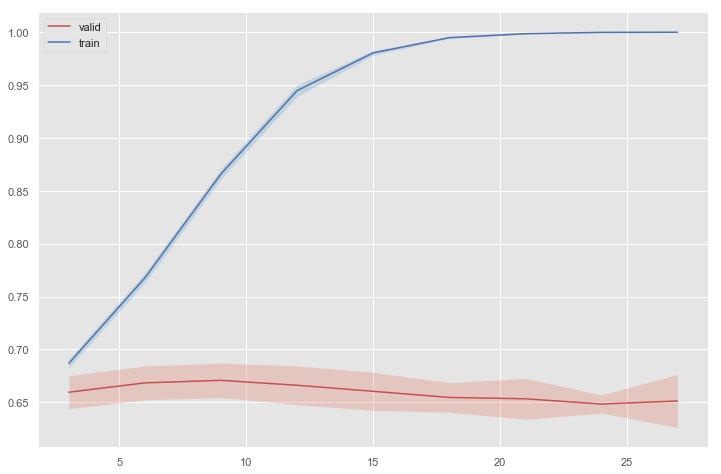

In [402]:
_range = [i*3 for i in range(1, 10)]
plt.plot(_range, mean_valid_scores, label='valid', c='r')
plt.fill_between(_range, mean_valid_scores-std_valid_scores, 
                 mean_valid_scores+std_valid_scores, alpha=0.2)
plt.plot(_range, mean_train_scores, label='train', c='b')
plt.fill_between(_range, mean_train_scores-std_train_scores, 
                 mean_train_scores+std_train_scores, alpha=0.2)

plt.legend()

In [404]:
# Проверка метрик
model1 = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators = 20, max_depth=6)
model1.fit(bin_X_train, bin_y_train)
model2 = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators = 20, max_depth=21)
model2.fit(bin_X_train, bin_y_train)

RandomForestClassifier(bootstrap=True, class_weight=u'balanced',
            criterion='gini', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [418]:
y_pred1 = model1.predict(bin_X_test)
print 'Accuracy: %f' % metrics.accuracy_score(bin_y_test, y_pred1)
print 'F1-score: %f' % metrics.f1_score(bin_y_test, y_pred1)
print 'Precision: %f' % metrics.precision_score(bin_y_test, y_pred1)
print 'Recall: %f' % metrics.recall_score(bin_y_test, y_pred1)
print 'ROC-AUC score: %f' % metrics.roc_auc_score(bin_y_test, y_pred1)

fpr, tpr, thresholds = metrics.roc_curve(bin_y_test, y_pred1, pos_label=1)
print 'AUC: %f' % metrics.auc(fpr, tpr)

Accuracy: 0.653795
F1-score: 0.197399
Precision: 0.120336
Recall: 0.548936
ROC-AUC score: 0.605774
AUC: 0.605774


(array([0, 1]), <a list of 2 Text yticklabel objects>)

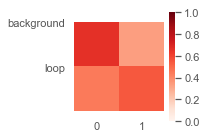

In [420]:
conf_mtrx = metrics.confusion_matrix(bin_y_test, y_pred1)#metrics.confusion_matrix(bin_y_test, y_pred1)
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T

plt.figure(figsize=[2,2])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True)
plt.yticks(np.arange(2), ['background', 'loop']) 
plt.yticks(rotation=0) 

In [421]:
y_pred2 = model2.predict(bin_X_test)
print 'Accuracy: %f' % metrics.accuracy_score(bin_y_test, y_pred2)
print 'F1-score: %f' % metrics.f1_score(bin_y_test, y_pred2)
print 'Precision: %f' % metrics.precision_score(bin_y_test, y_pred2)
print 'Recall: %f' % metrics.recall_score(bin_y_test, y_pred2)
print 'ROC-AUC score: %f' % metrics.roc_auc_score(bin_y_test, y_pred2)

fpr, tpr, thresholds = metrics.roc_curve(bin_y_test, y_pred2, pos_label=1)
print 'AUC: %f' % metrics.auc(fpr, tpr)

Accuracy: 0.913531
F1-score: 0.096552
Precision: 0.254545
Recall: 0.059574
ROC-AUC score: 0.522453
AUC: 0.522453


(array([0, 1]), <a list of 2 Text yticklabel objects>)

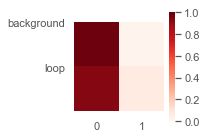

In [423]:
conf_mtrx = metrics.confusion_matrix(bin_y_test, y_pred2)
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T

plt.figure(figsize=[2,2])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True)
plt.yticks(np.arange(2), ['background', 'loop']) 
plt.yticks(rotation=0) 

Перебор параметров RandomizedSearchCV

In [428]:
param_grid = {
    'max_depth': range(1, 20),
    'n_estimators': [i*10 for i in range(1,11)] + [150, 200, 250, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 0.3, 0.5, 0.7],
    'min_samples_split': [50, 100, 150, 200, 250, 300, 350], 
    'min_samples_leaf': [i*10 for i in range(1,11)]
}

X_train, X_test, y_train, y_test = train_test_split(X, bin_y, test_size=0.2, random_state=42)
model_cv = RandomForestClassifier(random_state=42, class_weight='balanced')
search_cv = RandomizedSearchCV(model_cv, param_grid, n_iter=10, scoring='precision_weighted', n_jobs=-1, 
                               cv=5, random_state=42)
search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=u'balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={u'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], u'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300], u'min_samples_split': [50, 100, 150, 200, 250, 300, 350], u'criterion': [u'gini', u'entropy'], u'max_features': [None, u'sqrt', 0.3, 0.5, 0.7], u'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
          pre_dispatch='

In [2739]:
search_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 0.7,
 'min_samples_leaf': 50,
 'min_samples_split': 200,
 'n_estimators': 50}

In [768]:
bin_X_train, bin_X_test, bin_y_train, bin_y_test = train_test_split(X, bin_y, test_size=0.2, random_state=42)
bin_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', max_depth=6, 
                                   max_features=0.7, min_samples_leaf=50, min_samples_split=200,
                                   criterion='entropy')
bin_model.fit(bin_X_train, bin_y_train)
bin_y_pred = bin_model.predict(bin_X_test)

In [467]:
y_pred = bin_model.predict(X_test) 
print 'Accuracy: %f' % metrics.accuracy_score(bin_y_test, y_pred)
print 'Balanced accuracy: %f' % metrics.balanced_accuracy_score(bin_y_test, y_pred)
print 'F1-score: %f' % metrics.f1_score(bin_y_test, y_pred, average='weighted')
print 'Auc: %f' % metrics.roc_auc_score(bin_y_test, y_pred)
print 'Precision: %f' % metrics.precision_score(bin_y_test, y_pred, average='weighted')
print 'Average precision: %f' % metrics.average_precision_score(bin_y_test, y_pred, average='weighted')
print 'Recall: %f' % metrics.recall_score(bin_y_test, y_pred, average='weighted')

Accuracy: 0.680618
Balanced accuracy: 0.619405
F1-score: 0.754278
Auc: 0.619405
Precision: 0.884805
Average precision: 0.105741
Recall: 0.680618


In [770]:
conf_mtrx = metrics.confusion_matrix(bin_y_test, bin_y_pred)
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T
cm 

array([[0.67191413, 0.32808587],
       [0.41276596, 0.58723404]])

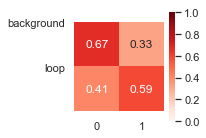

In [771]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[2,2])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True, annot=True)
plt.yticks(np.arange(2), ['background', 'loop'])
plt.yticks(rotation=0) 
plt.show()

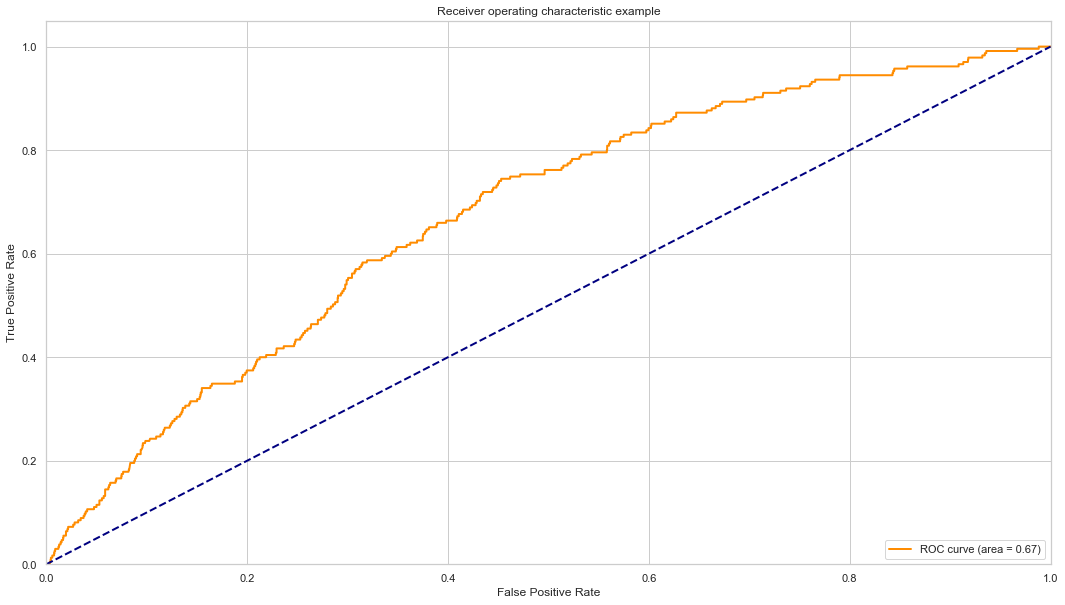

In [363]:
from sklearn.metrics import roc_curve, auc
lw = 2
y_pred_proba = bin_model.predict_proba(X_test) #search_cv.best_estimator_.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [364]:
imp = pd.Series(index=columns, data=model.feature_importances_)
imp.sort_values(ascending=False)[:15]

AG                   0.235452
AAA                  0.101003
CA                   0.089534
hbx5-1_M0873_1.02    0.078190
T                    0.064893
TTT                  0.064478
TT                   0.051061
mybG_M1351_1.02      0.043559
TGT                  0.037047
G/C                  0.035129
A/T                  0.029625
CTT                  0.026123
TCT                  0.022184
hbx10_M0878_1.02     0.020199
GA                   0.019221
dtype: float64

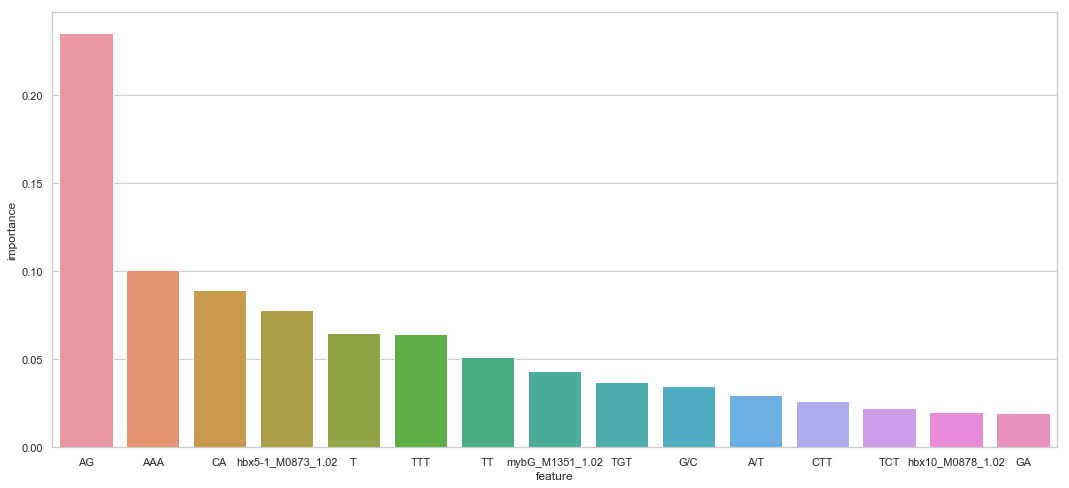

In [463]:
sns.set(style="whitegrid", rc = {'figure.figsize':(18,8)})
ax = sns.barplot(x="feature", y="importance", data=imp_feat)
plt.show()

### 2. Мультиклассовый классификатор

In [106]:
# 5 самых частых мотивов + важные фичи по хим. составу
columns = ['T', 'A', 'G', 'GA', 'CA', 'TT', 'TC', 'AG', 'CG', \
           'AGG', 'AGA', 'AGT', 'ACA', 'ATC', 'AAG', 'AAA', 'AAC', \
           'AAT', 'CAA', 'CAG', 'ACT', 'ACG', 'CTG', 'A/T/G', 'A/T', 'G/C', \
           'g4', 'DDB_G0270590_M1714_1.02', 'hbx5-2_M0874_1.02', \
           'hbx5-1_M0873_1.02', 'mybE_M1349_1.02', 'hbx10_M0878_1.02']

In [107]:
# все мотивы + важные фичи по хим. составу
columns = ['T', 'A', 'G', 'GA', 'CA', 'TT', 'TC', 'AG', 'CG', \
           'AGG', 'AGA', 'AGT', 'ACA', 'ATC', 'AAG', 'AAA', 'AAC', \
           'AAT', 'CAA', 'CAG', 'ACT', 'ACG', 'CTG', 'A/T/G', 'A/T', 'G/C', \
           'g4'] + m_names.keys()

In [670]:
columns = ['A', 'T', 'G', 'C', 'A/T', 'G/C', 'GG', 'GA', 'CA', 'CT', 'TT', 'TC', 'AG', \
           'AGG', 'AGC', 'AGA', 'AGT', 'ATG', 'ACA', 'ATC', 'AAG','AAA', 'AAC', 'AAT', \
           'CTT', 'CTG', 'CAA', 'CAG', 'TAT', 'TAG', 'TCT', 'TTT', 'TTC', 'TTG', \
           'TCA', 'TGT', 'TGG', 'GCC', 'GCA', 'GAA', 'GAT', 'g4'
          ] + m_names.keys()

In [681]:
columns = all_loops_df.columns
len(columns)

126

In [697]:
len(loops_df.columns),np.shape(X), np.shape(X_train)

(126, (15147, 126), (12117, 79))

In [682]:
loops_df = all_loops_df[columns]
loops_extr_df = all_loops_extr_df[columns]
inner_loops_df = all_inner_loops_df[columns]
outer_loops_df = all_outer_loops_df[columns]

In [683]:
X = [row.tolist() for _,row in loops_df.iterrows()]
X = X + [row.tolist() for _,row in loops_extr_df.iterrows()]
X = X + [row.tolist() for _,row in inner_loops_df.iterrows()]
X = X + [row.tolist() for _,row in outer_loops_df.iterrows()]

y = [1] * len(loops_df)
y = y + [3] * len(loops_extr_df)
y = y + [2] * len(inner_loops_df)
y = y + [0] * len(outer_loops_df)

Выбор метрики

In [574]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators = 20)
train_scores, valid_scores = validation_curve(model, X_train, y_train, 'max_depth', \
                                              [i*3 for i in range(1, 10)], cv=5, 
                                              scoring='f1_weighted', n_jobs=-1)

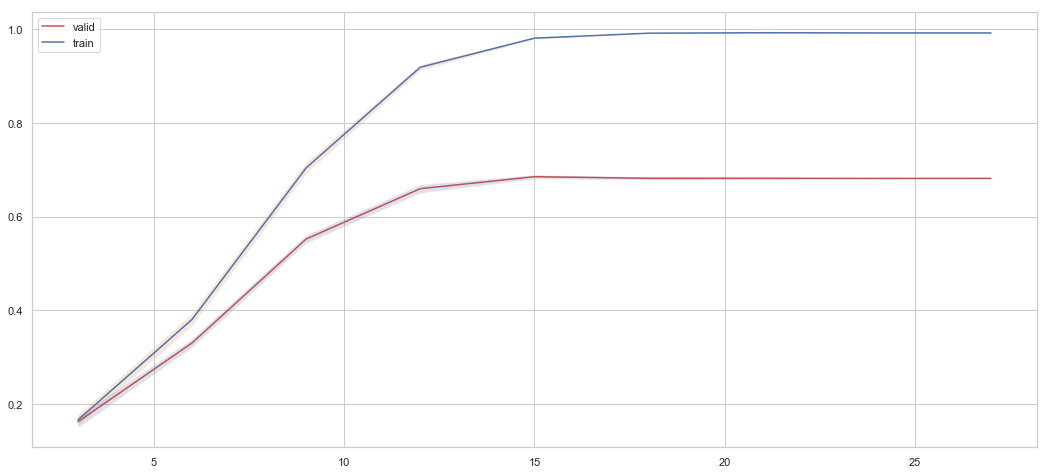

In [577]:
_range = [i*3 for i in range(1, 10)]
plt.plot(_range, mean_valid_scores, label='valid', c='r')
plt.fill_between(_range, mean_valid_scores-std_valid_scores, 
                 mean_valid_scores+std_valid_scores, alpha=0.2)
plt.plot(_range, mean_train_scores, label='train', c='b')
plt.fill_between(_range, mean_train_scores-std_train_scores, 
                 mean_train_scores+std_train_scores, alpha=0.2)

plt.legend()

In [578]:
# Проверка метрик
model1 = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators = 20, max_depth=6)
model1.fit(X_train, y_train)
model2 = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators = 20, max_depth=21)
model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=u'balanced',
            criterion='gini', max_depth=21, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=None, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [744]:
y_pred1 = model1.predict(X_train)#(X_test)
print 'Accuracy: %f' % metrics.balanced_accuracy_score(y_train, y_pred1)
print 'F1-score: %f' % metrics.f1_score(y_train, y_pred1, average='weighted')
print 'Precision: %f' % metrics.precision_score(y_train, y_pred1, average='weighted')
print 'Recall: %f' % metrics.recall_score(y_train, y_pred1, average='weighted')

Accuracy: 0.604959
F1-score: 0.334516
Precision: 0.750096
Recall: 0.302220


In [598]:
conf_mtrx = metrics.confusion_matrix(y_train, y_pred1)#metrics.confusion_matrix(bin_y_test, y_pred1)
print conf_mtrx
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T
cm

[[2016 2856 3215 1328]
 [  57  569  125  105]
 [ 146  339  990  282]
 [   0    0    2   87]]


array([[0.21412639, 0.30334572, 0.34147637, 0.14105151],
       [0.06658879, 0.66471963, 0.14602804, 0.12266355],
       [0.08309619, 0.19294252, 0.56346044, 0.16050085],
       [0.        , 0.        , 0.02247191, 0.97752809]])

(array([0, 1, 2, 3]), <a list of 4 Text yticklabel objects>)

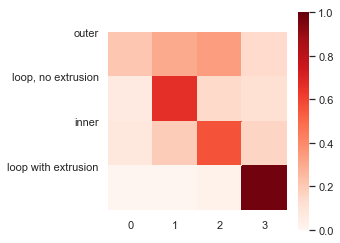

In [599]:
import seaborn as sns
plt.figure(figsize=[4,4])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True)
plt.yticks(np.arange(4), ['outer', 'loop, no extrusion', 'inner', 'loop with extrusion']) 
plt.yticks(rotation=0) 

In [600]:
y_pred2 = model2.predict(X_train)#(X_test)
print 'Accuracy: %f' % metrics.balanced_accuracy_score(y_train, y_pred2)
print 'F1-score: %f' % metrics.f1_score(y_train, y_pred2, average='weighted')
print 'Precision: %f' % metrics.precision_score(y_train, y_pred2, average='weighted')
print 'Recall: %f' % metrics.recall_score(y_train, y_pred2, average='weighted')

Accuracy: 0.974420
F1-score: 0.990866
Precision: 0.991042
Recall: 0.990922


In [601]:
conf_mtrx = metrics.confusion_matrix(y_train, y_pred2)
print conf_mtrx
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T
cm

[[9412    0    0    3]
 [  31  823    0    2]
 [  70    0 1685    2]
 [   2    0    0   87]]


array([[9.99681360e-01, 0.00000000e+00, 0.00000000e+00, 3.18640467e-04],
       [3.62149533e-02, 9.61448598e-01, 0.00000000e+00, 2.33644860e-03],
       [3.98406375e-02, 0.00000000e+00, 9.59021059e-01, 1.13830393e-03],
       [2.24719101e-02, 0.00000000e+00, 0.00000000e+00, 9.77528090e-01]])

(array([0, 1, 2, 3]), <a list of 4 Text yticklabel objects>)

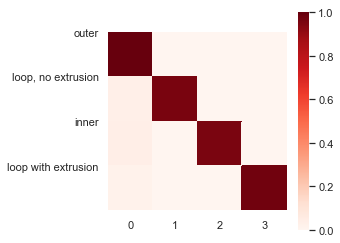

In [602]:
import seaborn as sns
plt.figure(figsize=[4,4])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True)
plt.yticks(np.arange(4), ['outer', 'loop, no extrusion', 'inner', 'loop with extrusion']) 
plt.yticks(rotation=0) 

In [674]:
param_grid = {
    'max_depth': range(1, 20),
    'n_estimators': [i*10 for i in range(1,11)] + [150, 200, 250, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 0.3, 0.5, 0.7],
    'min_samples_split': [50, 100, 150, 200, 250, 300, 350], 
    'min_samples_leaf': [i*10 for i in range(1,11)]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_cv = RandomForestClassifier(random_state=42, class_weight='balanced')
search_cv = RandomizedSearchCV(model_cv, param_grid, n_iter=10, scoring='precision_weighted', n_jobs=-1, 
                               cv=5, random_state=42)
search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=u'balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={u'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], u'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300], u'min_samples_split': [50, 100, 150, 200, 250, 300, 350], u'criterion': [u'gini', u'entropy'], u'max_features': [None, u'sqrt', 0.3, 0.5, 0.7], u'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
          pre_dispatch='

In [789]:
y_pred2 = search_cv.best_estimator_.predict(X_test)
print 'Accuracy: %f' % metrics.balanced_accuracy_score(y_test, y_pred2)
print 'F1-score: %f' % metrics.f1_score(y_test, y_pred2, average='weighted')
print 'Precision: %f' % metrics.precision_score(y_test, y_pred2, average='weighted')
print 'Recall: %f' % metrics.recall_score(y_test, y_pred2, average='weighted')

Accuracy: 0.527613
F1-score: 0.434209
Precision: 0.694313
Recall: 0.435822


In [790]:
conf_mtrx = metrics.confusion_matrix(y_test, y_pred2)
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T
cm

array([[0.33389687, 0.2476754 , 0.29374472, 0.12468301],
       [0.23364486, 0.44859813, 0.1588785 , 0.1588785 ],
       [0.25407925, 0.17482517, 0.42890443, 0.14219114],
       [0.        , 0.        , 0.19047619, 0.80952381]])

(array([0, 1, 2, 3]), <a list of 4 Text yticklabel objects>)

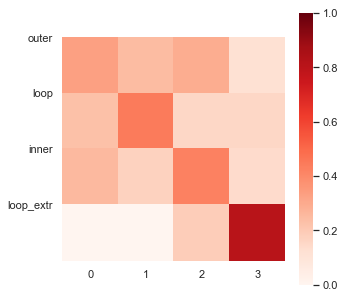

In [791]:
import seaborn as sns

plt.figure(figsize=[5,5])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True)
plt.yticks(np.arange(4), ['outer', 'loop', 'inner', 'loop_extr'])
plt.yticks(rotation=0) 

Перебор параметров и confusion matrices

In [679]:
cm_s = [] # estimators:{depth:cm}
p_s = []
params = {'estimators' : [20,30,40,50],
          'max_depth' : range(5,20),
          #'max_features': [0.3, 0.5, 0.7],
          'min_samples_split': [100, 150, 200, 250], 
          'min_samples_leaf': [i*10 for i in range(5,10)]
         }
max_f = 0.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print datetime.datetime.now().time()
for est in params['estimators']:
    for depth in params['max_depth']:
        #for max_f in params['max_features']:
        for min_s_split in params['min_samples_split']:
            for min_s_leaf in params['min_samples_leaf']:
                model_cv = RandomForestClassifier(n_estimators=est, random_state=42, \
                                               class_weight='balanced', max_depth=depth, \
                                                 criterion='entropy', \
                                                 min_samples_split=min_s_split, \
                                                  min_samples_leaf=min_s_leaf)
                model_cv.fit(X_train, y_train)

                y_pred = model_cv.predict(X_test)
                conf_mtrx = metrics.confusion_matrix(y_test, y_pred)
                cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T
                cm_s.append(cm)
                p = 'est: %i, depth: %i, max_f: %f, m_s_split: %i, m_s_leaf: %i' % \
                    (est, depth, max_f, min_s_split, min_s_leaf)
                p_s.append(p)
print datetime.datetime.now().time()


18:32:08.465296
18:43:13.519531


In [630]:
for p in p_s:
    print p

est: 20, depth: 5, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 6, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 7, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 8, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 9, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 10, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 11, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 12, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 13, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 14, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 15, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 16, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 17, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 18, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 20, depth: 19, max_f: 0.000000, m_s_split: 250, m_s_leaf: 70
est: 30, depth:

/Users/victoria/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


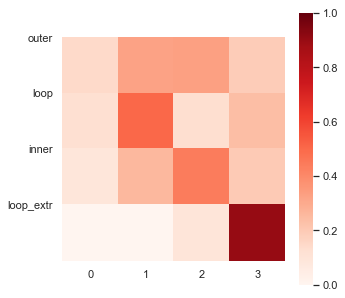

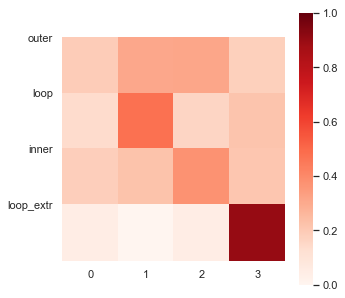

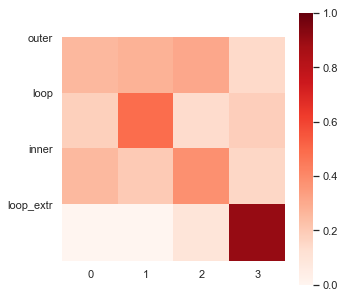

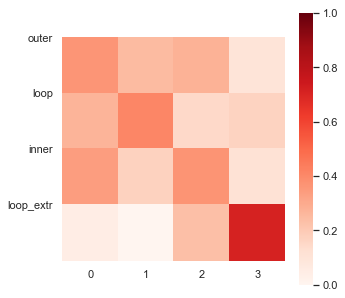

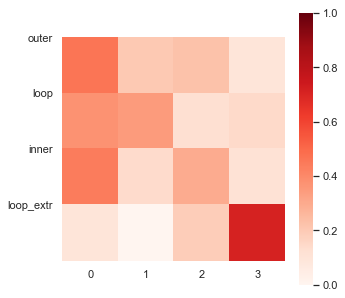

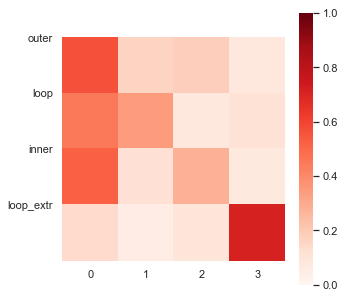

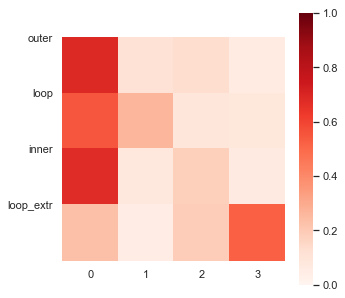

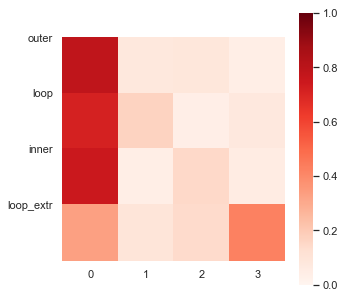

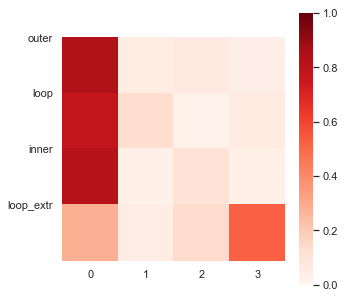

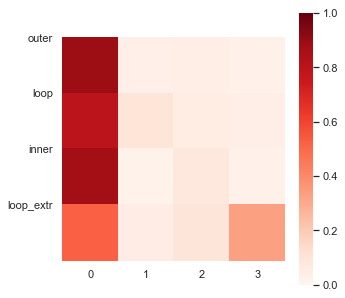

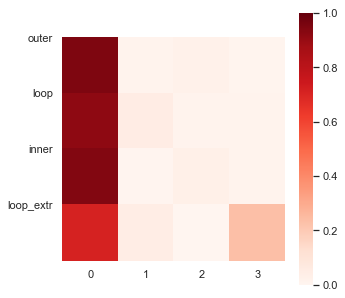

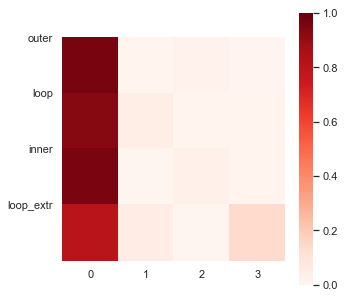

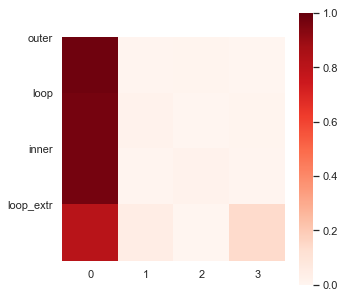

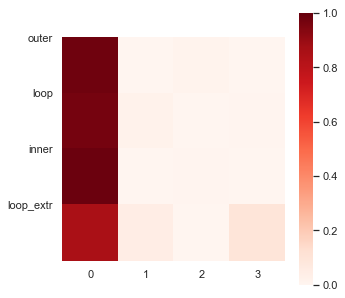

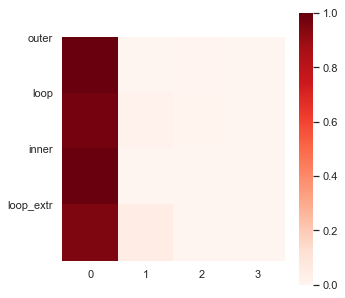

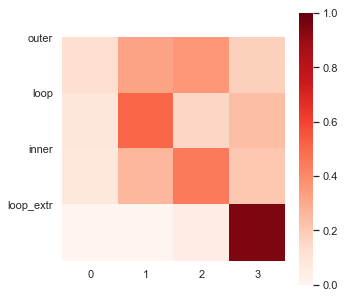

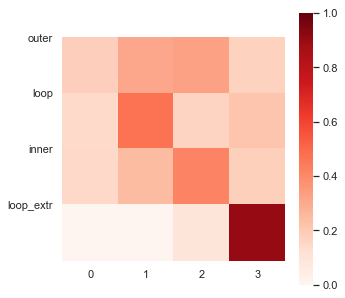

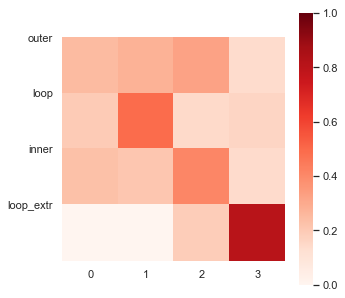

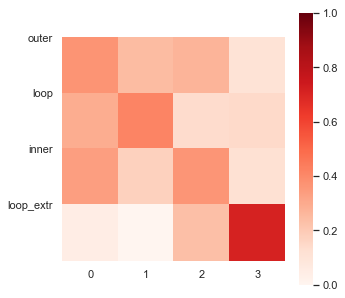

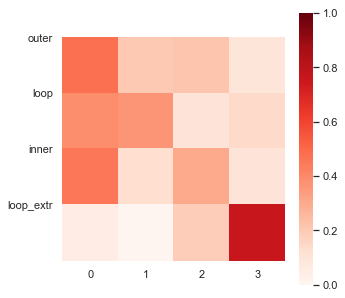

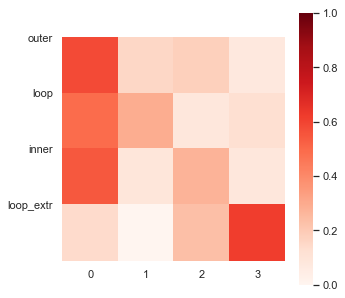

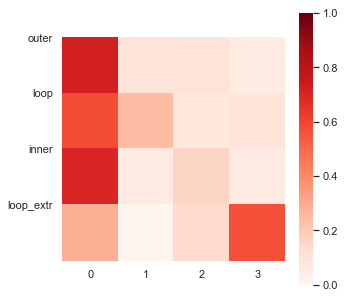

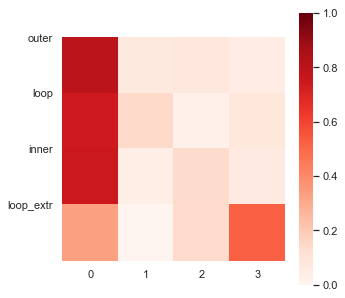

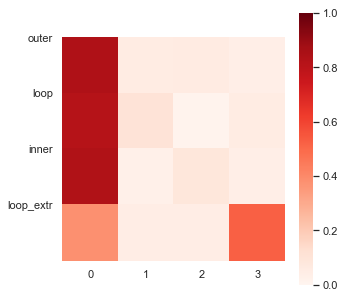

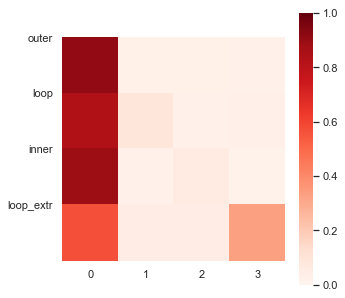

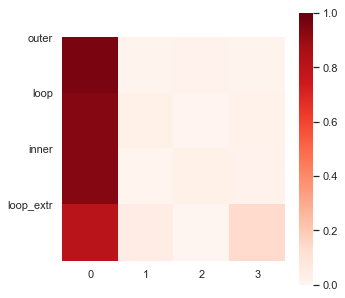

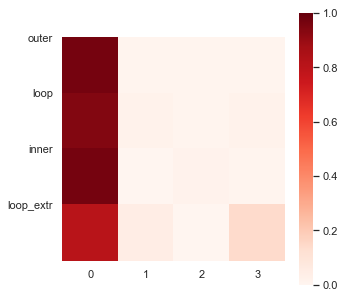

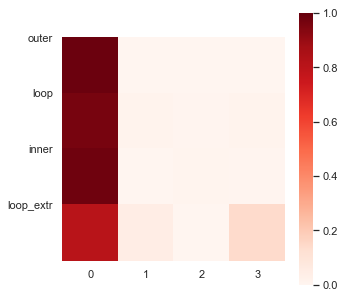

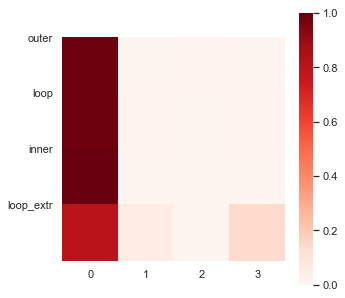

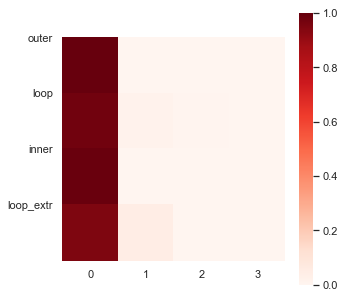

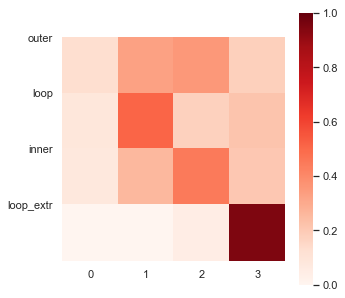

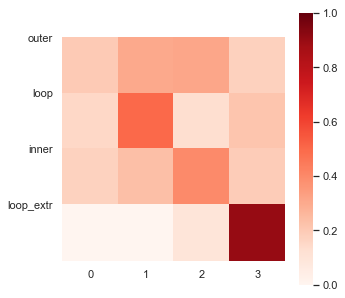

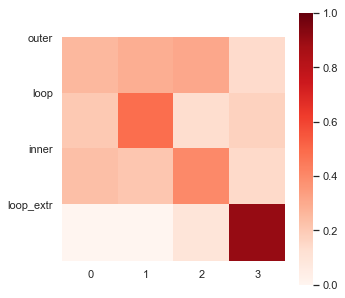

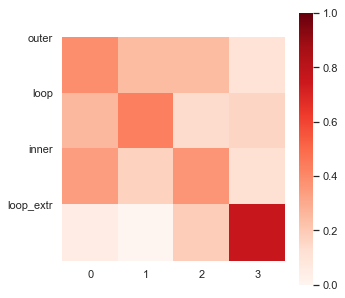

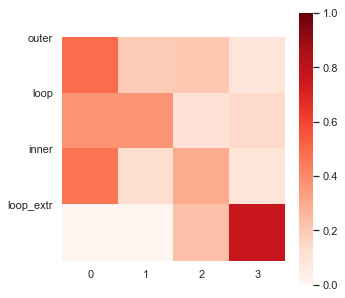

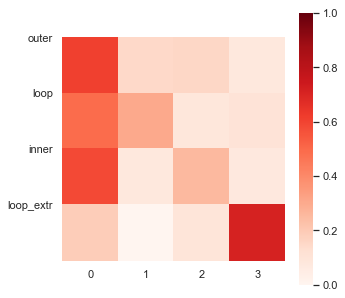

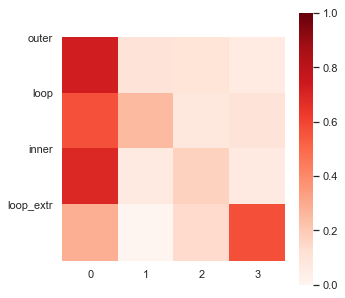

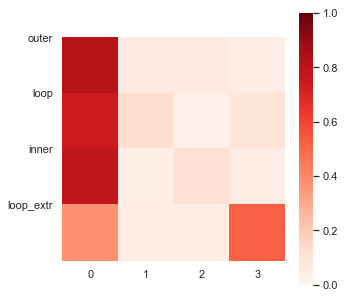

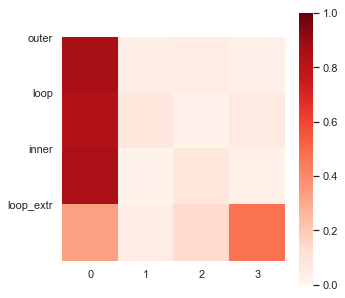

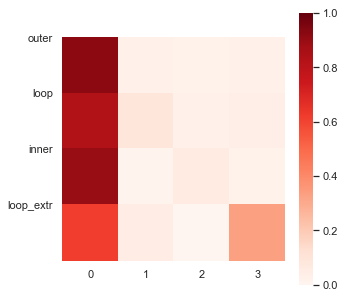

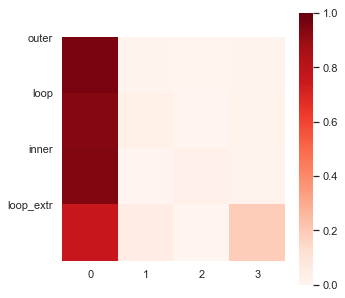

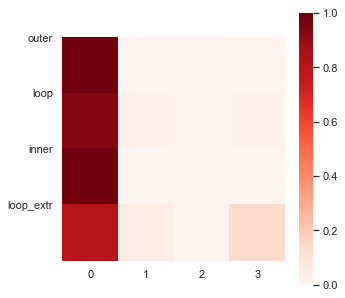

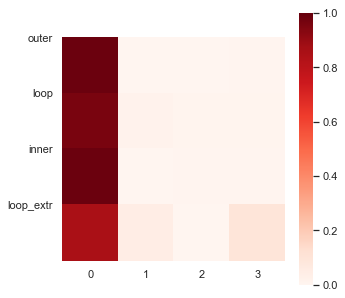

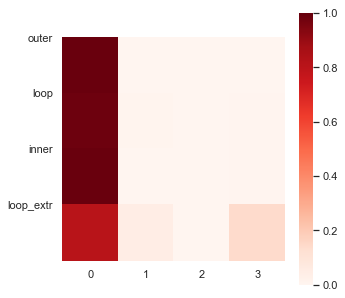

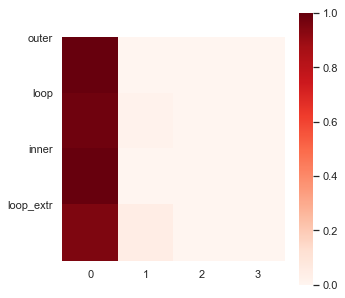

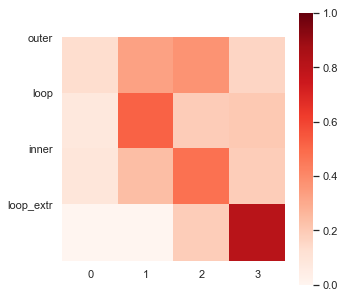

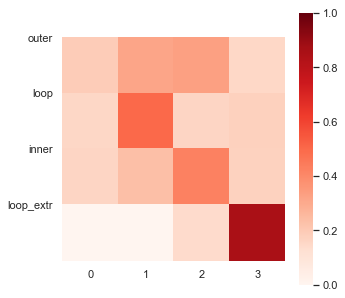

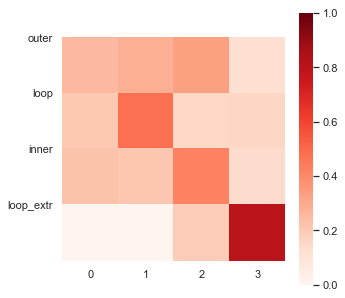

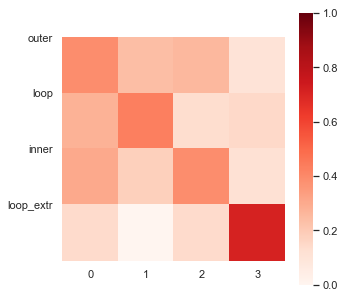

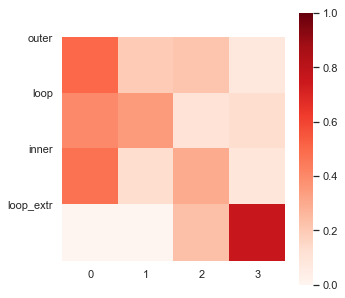

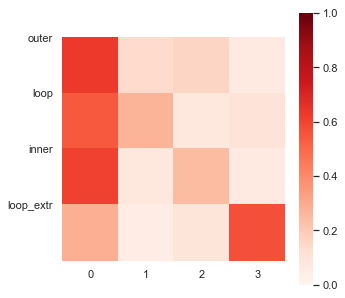

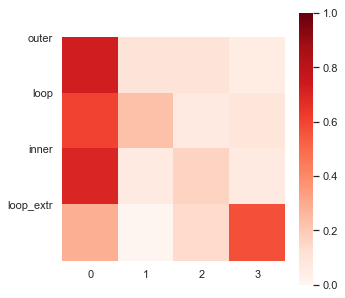

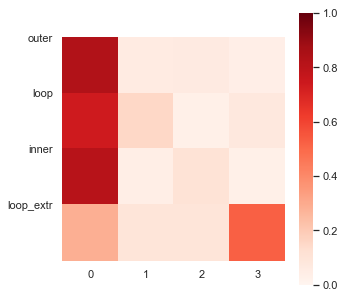

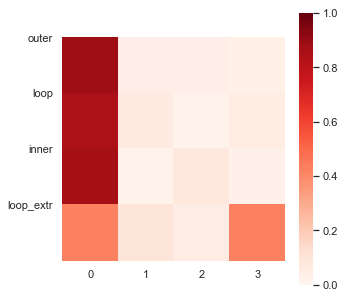

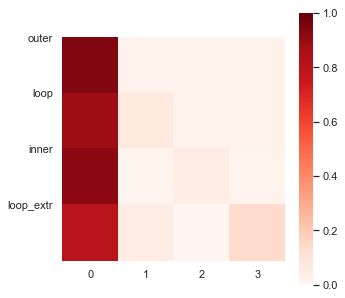

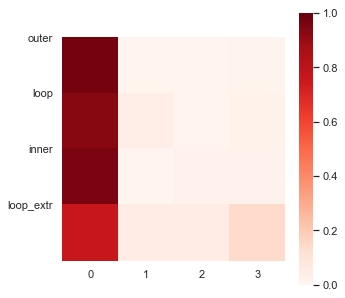

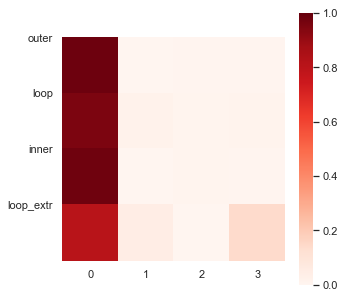

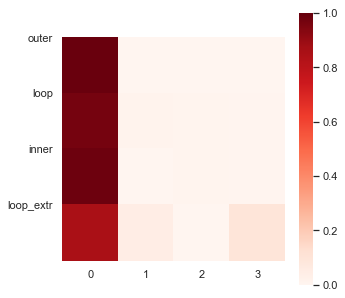

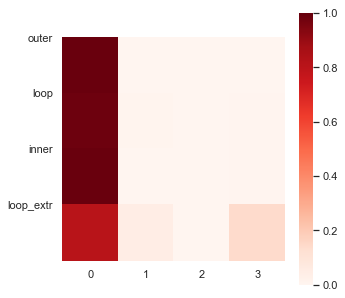

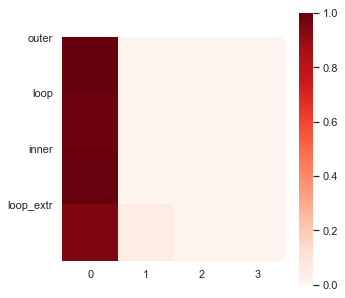

In [629]:
# все фичи
for _cm in cm_s:
    plt.figure(figsize=[5,5])
    sns.heatmap(_cm, cmap='Reds', vmax=1, vmin=0, square=True)
    plt.yticks(np.arange(4), ['outer', 'loop', 'inner', 'loop_extr'])
    plt.yticks(rotation=0) 

In [776]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model = model_cv = RandomForestClassifier(n_estimators=50, random_state=42, \
                                       class_weight='balanced', max_depth=9, \
                                               max_features=0.7, \
                                               min_samples_leaf=50, \
                                               min_samples_split=150)
best_model.fit(X_train, y_train)

In [778]:
y_pred = best_model.predict(X_test)
print 'Accuracy: %f' % metrics.balanced_accuracy_score(y_test, y_pred)
print 'F1-score: %f' % metrics.f1_score(y_test, y_pred, average='weighted')
print 'Precision: %f' % metrics.precision_score(y_test, y_pred, average='weighted')
print 'Recall: %f' % metrics.recall_score(y_test, y_pred, average='weighted')

Accuracy: 0.527613
F1-score: 0.434209
Precision: 0.694313
Recall: 0.435822


In [779]:
conf_mtrx = metrics.confusion_matrix(y_test, y_pred)
cm = (conf_mtrx.T*1.0 / np.sum(conf_mtrx, axis=1)).T

(array([0, 1, 2, 3]), <a list of 4 Text yticklabel objects>)

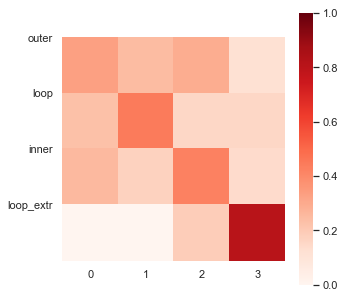

In [780]:
plt.figure(figsize=[5,5])
sns.heatmap(cm, cmap='Reds', vmax=1, vmin=0, square=True)
plt.yticks(np.arange(4), ['outer', 'loop', 'inner', 'loop_extr'])
plt.yticks(rotation=0)

In [783]:
imp = pd.Series(index=loops_df.columns.values, data=best_model.feature_importances_)
imp.sort_values(ascending=False)[:15]

hbx5-1_M0873_1.02    0.198788
mybG_M1351_1.02      0.133481
gbfA_M1673_1.02      0.052445
hbx10_M0878_1.02     0.050803
bzpH_M0283_1.02      0.040339
CAA                  0.034480
AG                   0.027872
G                    0.023764
AAA                  0.023489
TTT                  0.021462
CA                   0.020422
AGA                  0.017375
T                    0.014162
CT                   0.013649
AT                   0.013016
dtype: float64

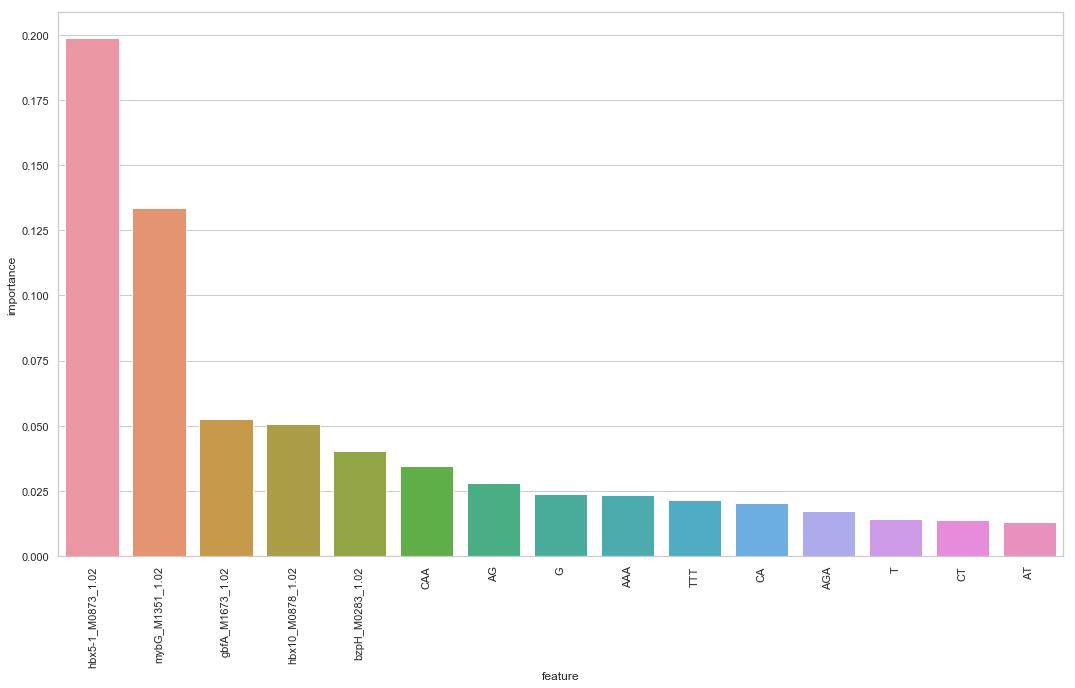

In [784]:
features_df = pd.DataFrame(columns=['feature', 'importance'])
features_df['feature'] = loops_df.columns.values
features_df['importance'] = best_model.feature_importances_
features_df = features_df.sort_values(by=['importance'], ascending=False)
sns.set(style="whitegrid", rc = {'figure.figsize':(18,10)})
ax = sns.barplot(x='feature', y='importance', data=features_df[:15])
ax.set_xticklabels(labels = plt.xticks()[1], rotation=90)
plt.show()

In [785]:
# на половине данных
X_train, X_test, y_train, y_test = train_test_split(X, bin_y, test_size=0.5, random_state=42)
model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                criterion='entropy', max_depth=9, max_features=0.7,
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_impurity_split=None, min_samples_leaf=50,
                min_samples_split=150, min_weight_fraction_leaf=0.0,
                n_estimators=50, n_jobs=None, oob_score=False, random_state=42,
                verbose=0, warm_start=False)
model.fit(X_train, y_train)

In [734]:
imp = pd.Series(index=loops_df.columns.values, data=best_model.feature_importances_)
imp.sort_values(ascending=False)[:15]

hbx5-1_M0873_1.02    0.219437
mybG_M1351_1.02      0.132455
gbfA_M1673_1.02      0.045281
CAA                  0.040483
hbx10_M0878_1.02     0.034747
bzpH_M0283_1.02      0.028762
AG                   0.025044
AAA                  0.020419
CA                   0.020080
TTT                  0.018840
TT                   0.016945
CTT                  0.015342
T                    0.014975
G                    0.014924
AAG                  0.011905
dtype: float64

Важные фичи для разделения двух классов мультиклассового классификатора

In [749]:
def get_samples_gini(node):
    lbl = node.get_label()
    samples = lbl[lbl.find('samples = ') + 10:]
    samples = samples[:samples.find('\\')]
    gini = lbl[lbl.find('gini = ') + 7:]
    gini = gini[:gini.find('\\')]
    return int(samples), float(gini)
    
def get_feat_imp(node, left, right, all_samples):
    n_samples, n_gini = get_samples_gini(node)
    l_samples, l_gini = get_samples_gini(left)
    r_samples, r_gini = get_samples_gini(right)
    return (n_samples*1.0/all_samples)*n_gini \
            - (l_samples*1.0/all_samples)*l_gini \
            - (r_samples*1.0/all_samples)*r_gini

def get_graph_nodes_edges(est, feature_names):
    dot_data = StringIO()
    export_graphviz(est, filled=True, out_file=dot_data, feature_names=feature_names, 
                    class_names=['0','1','2','3'])
    gr = pydot.dot_parser.parse_dot_data(dot_data.getvalue())[0]
    return gr, gr.get_nodes(), gr.get_edges()

def normalize_imp_features(features_dic):
    sum_features_imp = sum(features_dic.values())
    return {k: v*1.0/sum_features_imp for k, v in features_dic.items()}

def get_imp_features_for_classes(class1, class2, model, feature_names):
    rf_imp_features = {}
    for j, tree in enumerate(model.estimators_):
        imp_features = {}
        all_imp_for_classes = 0 # importances of all nodes that split class1 and class2
        gr, nodes, edges = get_graph_nodes_edges(tree, feature_names)       
        samples, gini = get_samples_gini(gr.get_node('0')[0])
        for i in range(0, len(nodes)):
            cur_edges = [e for e in edges if e.get_source() == str(i)] # children for i-th node
            if (len(cur_edges) == 0): # if there is no children
                continue
            l = cur_edges[0].get_destination()
            r = cur_edges[1].get_destination()
            node_l = gr.get_node(l)
            node_r = gr.get_node(r)
            if (len(node_l) == 0) or (len(node_r) == 0):
                print 'Error ', j, i, len(cur_edges)
            node_l = node_l[0]
            node_r = node_r[0]
            lbl_l = node_l.get_label()
            lbl_r = node_r.get_label()
            cl_l = lbl_l[lbl_l.rfind('nclass = ') + 9:]
            cl_l = int(cl_l.replace('"', ''))
            cl_r = lbl_r[lbl_r.rfind('nclass = ') + 9:]
            cl_r = int(cl_r.replace('"', ''))
            if ((cl_l == class1) and (cl_r == class2)) or \
                ((cl_l == class2) and (cl_r == class1)):
                    parent = gr.get_node(str(i))[0]
                    lbl = parent.get_label()
                    feature = lbl[1:lbl.find(' <=')]
                    imp = get_feat_imp(parent, node_l, node_r, samples)
                    imp_features[feature] = imp_features.get(feature, 0) + imp
                    all_imp_for_classes = all_imp_for_classes + imp
                    #print j, i
        imp_features = {k: v*1.0/all_imp_for_classes for k, v in imp_features.items()}
        imp_features = normalize_imp_features(imp_features)
        for k,v in imp_features.iteritems():
            rf_imp_features[k] = rf_imp_features.get(k, 0) + v
    rf_imp_features = {k: v*1.0/len(model.estimators_) for k, v in rf_imp_features.items()}
    return rf_imp_features

In [660]:
# важные для разделения 1 и 3 класса
imp_features = get_imp_features_for_classes(1, 3, best_model, loops_df.columns)
sorted(imp_features.items(), key=lambda x: x[1], reverse=True)

[(u'hbx5-1_M0873_1.02', 0.5903385095865744),
 (u'mybG_M1351_1.02', 0.23394200059325515),
 (u'hbx10_M0878_1.02', 0.06434087007412942),
 (u'bzpH_M0283_1.02', 0.054706080767760505),
 (u'hbx5-2_M0874_1.02', 0.037851330522468134),
 (u'gbfA_M1673_1.02', 0.007904965478120593),
 (u'G', 0.004403313558035829),
 (u'DDB_G0275333_M0101_1.02', 0.002051109805173085),
 (u'TTT', 0.0014610133172162267),
 (u'T/G/C', 0.001248710478544793),
 (u'gtaE_M0773_1.02', 0.0009622054557360259),
 (u'TCA', 0.0008237056782198501),
 (u'mybV_M1348_1.02', 0.0002342687892701404),
 (u'T', -0.0002680841045041192)]

In [746]:
imp_features2 = get_imp_features_for_classes(0, 2, best_model, loops_df.columns)
sorted(imp_features2.items(), key=lambda x: x[1], reverse=True)

0 10
0 46
0 49
0 54
0 57
0 68
0 90
0 94
0 101
0 123
Stat:  0.1 0.061112709371182766
Stat:  0.1 0.061112709371182766
1 62
1 69
1 76
1 102
1 103
1 104
1 105
1 108
1 120
Stat:  0.125 0.059803485203578394
Stat:  0.125 0.059803485203578394
2 41
2 44
2 73
2 76
2 89
2 91
2 95
2 103
Stat:  0.14285714285714285 0.046546407151515735
Stat:  0.14285714285714285 0.046546407151515735
3 3
3 8
3 14
3 22
3 27
3 73
3 83
3 86
3 87
Stat:  0.1111111111111111 0.04143373473598666
Stat:  0.1111111111111111 0.04143373473598666
4 8
4 11
4 17
4 46
4 56
4 57
4 62
4 63
4 80
4 84
4 85
4 86
4 88
4 96
4 99
Stat:  0.06666666666666668 0.04546919134408782
Stat:  0.06666666666666668 0.04546919134408782
5 15
5 51
5 60
5 85
5 87
5 95
5 96
Stat:  0.14285714285714285 0.06430074104992033
Stat:  0.14285714285714285 0.06430074104992033
6 41
6 61
6 62
6 93
6 96
6 97
6 100
6 106
Stat:  0.12499999999999999 0.04985834618876747
Stat:  0.12499999999999999 0.04985834618876747
7 20
7 52
7 53
7 56
7 86
7 88
7 103
7 130
Stat:  0.142857142

[(u'hbx5-1_M0873_1.02', 0.0930684701520903),
 (u'AAA', 0.04881082307148947),
 (u'AAT', 0.0473519116756997),
 (u'TTT', 0.03551567201576362),
 (u'CAA', 0.034439024454157786),
 (u'AT', 0.03353824360045001),
 (u'AG', 0.02796354505278572),
 (u'A', 0.026421953406790755),
 (u'AA', 0.02417591500498522),
 (u'ATT', 0.023720241382669736),
 (u'T', 0.021261053424518846),
 (u'G', 0.020766105268258603),
 (u'GA', 0.02074887173138132),
 (u'GGA', 0.019552195282163495),
 (u'CA', 0.018564821835504314),
 (u'AGG', 0.01750325991564294),
 (u'TAT', 0.01699269379052437),
 (u'CAG', 0.016953913088305884),
 (u'A/T/G', 0.016815592213830822),
 (u'TT', 0.016739097555269544),
 (u'TAG', 0.014567017088044793),
 (u'mybG_M1351_1.02', 0.013904625838084718),
 (u'A/T', 0.013798664455385422),
 (u'TTG', 0.01269498381164355),
 (u'T/G/C', 0.012449278690465491),
 (u'TAA', 0.01235574278497278),
 (u'CAT', 0.01231610675199759),
 (u'TGT', 0.011874679646714912),
 (u'TTA', 0.011436565466125245),
 (u'ACA', 0.010988427235241122),
 (u'TCT

In [750]:
imp_features3 = get_imp_features_for_classes(0, 1, best_model, loops_df.columns)
sorted(imp_features3.items(), key=lambda x: x[1], reverse=True)

[(u'CAA', 0.14468575905145964),
 (u'T', 0.05557982705038458),
 (u'AG', 0.051486752279125206),
 (u'CA', 0.0417862636790577),
 (u'TTT', 0.03887004897627496),
 (u'AAA', 0.0356018378224006),
 (u'AAG', 0.029456481885935425),
 (u'TT', 0.027805859637619057),
 (u'AGA', 0.025906090878755984),
 (u'TA', 0.024706850725255157),
 (u'mybG_M1351_1.02', 0.02445003776589287),
 (u'AGG', 0.02404254834814847),
 (u'T/G/C', 0.020897328994416934),
 (u'AAT', 0.018134660903985758),
 (u'G/C', 0.017810040164121695),
 (u'G', 0.016750693713009506),
 (u'hbx5-1_M0873_1.02', 0.016370821356666666),
 (u'AA', 0.015917552356909555),
 (u'hbx5-2_M0874_1.02', 0.01577484064045246),
 (u'TAT', 0.014149315314845463),
 (u'GG', 0.01375856498322721),
 (u'TAA', 0.012176651767889561),
 (u'TGA', 0.011869575683713112),
 (u'AGT', 0.011701342050205147),
 (u'CT', 0.011345606947697803),
 (u'CG', 0.010566318742080284),
 (u'CAG', 0.010504335823045193),
 (u'C', 0.010293292323301),
 (u'hbx10_M0878_1.02', 0.009915028005588342),
 (u'CAT', 0.0097

In [751]:
imp_features4 = get_imp_features_for_classes(1, 2, best_model, loops_df.columns)
sorted(imp_features4.items(), key=lambda x: x[1], reverse=True)

[(u'AG', 0.12208306423607533),
 (u'CAA', 0.08232149746988637),
 (u'AAG', 0.05857347096861393),
 (u'TTT', 0.0468674182462744),
 (u'AGG', 0.03939932682324319),
 (u'AGA', 0.03504941662413691),
 (u'mybG_M1351_1.02', 0.033344213612318256),
 (u'T/G/C', 0.03318998480460293),
 (u'hbx10_M0878_1.02', 0.030483396874886035),
 (u'TT', 0.027065042759757428),
 (u'G', 0.023974960194984286),
 (u'A/T', 0.022949469430745332),
 (u'GGA', 0.021761215847768023),
 (u'CA', 0.0216883914306561),
 (u'TAA', 0.02152533172450337),
 (u'T', 0.020697258895419277),
 (u'AAA', 0.018054030264334234),
 (u'hbx5-1_M0873_1.02', 0.01800046311378231),
 (u'AT', 0.017974144788049328),
 (u'AAT', 0.014501190435606723),
 (u'GG', 0.013229196799184826),
 (u'C', 0.01134304904242155),
 (u'ATT', 0.011337200667318723),
 (u'G/C', 0.010822182653995848),
 (u'CT', 0.010426939970988845),
 (u'TTG', 0.009529506558875205),
 (u'CTA', 0.009370995860863263),
 (u'ATC', 0.0088310977754955),
 (u'A', 0.008793628542151911),
 (u'GAT', 0.008325323449871557)

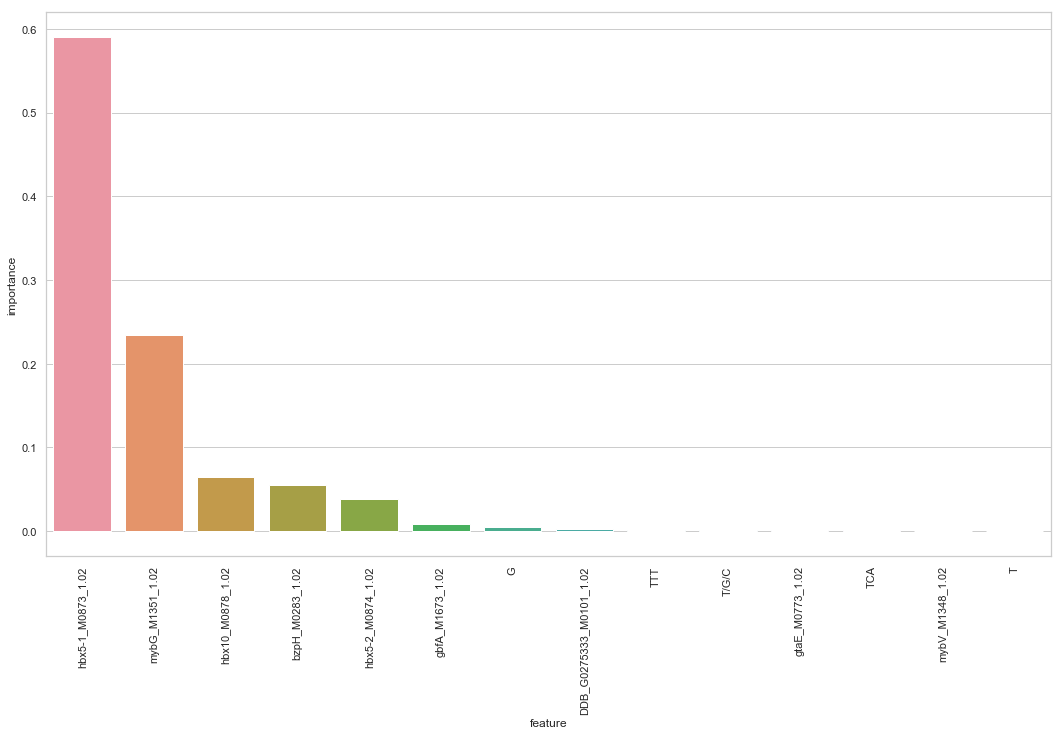

In [745]:
# важность для разделения 1 и 3 класса
features_df = pd.DataFrame(columns=['feature', 'importance'])
features_df['feature'] = imp_features.keys()
features_df['importance'] = imp_features.values()
features_df = features_df.sort_values(by=['importance'], ascending=False)
sns.set(style="whitegrid", rc = {'figure.figsize':(18,10)})
ax = sns.barplot(x='feature', y='importance', data=features_df[:15])
ax.set_xticklabels(labels = plt.xticks()[1], rotation=90)
plt.show()

### Рисуем деревья

In [1205]:
!pip install pydotplus

    100% |████████████████████████████████| 286kB 1.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for pydotplus ... done
  Stored in directory: /Users/victoria/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1223]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
bin_model.fit(bin_X_train, bin_y_train)

export_graphviz(bin_model.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True, feature_names=columns,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_png("../data/background/tree.png")

True